# Selection of $B_s \rightarrow \psi(2S)\,K_S$ events: A lab exercise

In this notebook you will perform the (most interesting) part of a **real physics data analysis** of the $B_s \rightarrow \psi(2S)\,K_S$ decay:  
The filtering of the tiny fraction of interesting events from the vast amount of total data that is recorded in the LHCb experiment at CERN.  
You will be learning about classification tasks in particle physics, utilizing machine learning algorithms and expert systems to squeeze out the best performance.  
But let's not panic, we go through it step by step!

We will work on three samples:
- The real data set.
- Monte-Carlo simulation of the signal decay $B_s \rightarrow \psi(2S)\,K_S$.
- Monte-Carlo simulation of the (kinematically) similar decay $B_d \rightarrow \psi(2S)\,K_S$.


Let's first define the paths to the samples.

In [1]:
# python plotting library
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

In [2]:
#actual data
path_to_data = "/data/Bs2psi2SKS/data.root"
#signal simulation
path_to_sim = "/data/Bs2psi2SKS/signal_sim.root"
#control channel simulation
path_to_control_sim = "/data/Bd2psi2SKS/control_sim.root"

The nomenclature here is:
 - data = the actual data coming from LHCb
 - signal sim = monte-carlo simulation of our signal decay $B_s \rightarrow \psi(2S)\,K_S$
 - control sim = monte-carlo simulation of the similar decay $B_d \rightarrow \psi(2S)\,K_S$

### Reading the data from a "ROOT" file

Everything at CERN works with [ROOT](https://root.cern.ch), also the output of our distributed data processing chain.  
ROOT is incredibly powerful, but also not too easy to use..  
Let's not try to make it work, but rather use [uproot](https://github.com/scikit-hep/uproot) to put our data into [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [3]:
def get_data(path, chunk_size=None, treename = 'Tree', branches = None):
    import numpy as np
    import uproot
    if not chunk_size:
        return uproot.open(path)[treename].pandas.df(branches=branches, flatten=False).replace([np.inf, -np.inf], np.nan).dropna()
    for data in uproot.open(path)[treename].pandas.iterate(entrysteps = chunk_size, flatten=False, branches=branches):
        return data.replace([np.inf, -np.inf], np.nan).dropna()

## 1. Data Exploration
Let's have a look at our simulation first.

**Ex 1.1: Get a dataframe of the signal simulation and plot the invariant $B_s$ mass.**  
<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">The name is B_FitDaughtersConst_M_flat</a></h4>

In [4]:
df_data = get_data(path_to_data)
df_MC = get_data(path_to_sim)
df_MC_ctrl = get_data(path_to_control_sim)

In [5]:
df_data.columns

Index(['B_LOKI_ENERGY', 'B_LOKI_ETA', 'B_LOKI_PHI', 'B_Vtx_Chi2NDOF',
       'B_MINIP', 'B_MINIPCHI2', 'B_MINIPNEXTBEST', 'B_MINIPCHI2NEXTBEST',
       'B_ENDVERTEX_X', 'B_ENDVERTEX_Y',
       ...
       'L0DiMuonDecision', 'L0HadronDecision', 'L0ElectronDecision',
       'L0PhotonDecision', 'L0nSelections', 'MaxRoutingBits', 'year',
       'rndm_Number', 'sweights_sig', 'sweights_bkg'],
      dtype='object', length=863)

In [6]:
print(min(df_MC["B_FitDaughtersConst_M_flat"]))
print(max(df_MC["B_FitDaughtersConst_M_flat"]))

5144.9228515625
5599.458984375


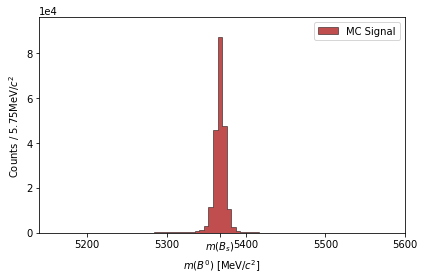

In [7]:
xr = (5140, 5600)
bins = 80

m_Bs = 5366.88

bins = np.linspace(*xr, bins+1)

centers = (bins[:-1] + bins[1:]) / 2
width = np.sum(bins[1:] - bins[:-1]) / len(centers)

fig, ax = plt.subplots(1, 1)
counts, _, _ = ax.hist(df_MC["B_FitDaughtersConst_M_flat"], bins = bins, label = "MC Signal", 
                       color = "firebrick", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled")

plt.xlabel(r"$m(B^0)$ [MeV/$c^2$]")
plt.ylabel(f"Counts / {width}" + r"MeV/$c^2$")
plt.legend()
plt.xlim(*xr)
plt.ylim(0, 1.1*max(counts))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ticks = list(ax.get_xticks()) + [m_Bs]
labels = [str(int(tick)) for tick in ticks]
labels[-1] = r"$m(B_s)$"
plt.xticks(ticks = ticks, labels = labels)
plt.xlim(*xr)
plt.tight_layout();

#fig.savefig("plots/mass_signal.pdf")

Your plot should show a peaking structure near the nominal $B_s$ mass: $m(B_s) = 5366.88\,\text{MeV}$.


Let's do the same for our data:

**Ex 1.2: Plot the invariant $B_s$ mass of the data.**

In [8]:
print(min(df_data["B_FitDaughtersConst_M_flat"]))
print(max(df_data["B_FitDaughtersConst_M_flat"]))

5100.00048828125
6099.99609375


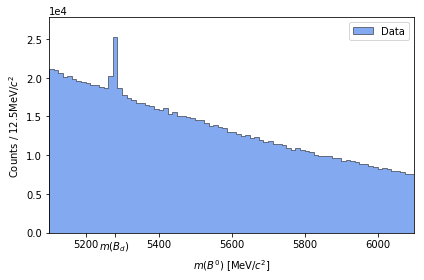

In [9]:
xr = (5100, 6100)
bins = 80

m_Bd = 5279.65

bins = np.linspace(*xr, bins+1)

centers = (bins[:-1] + bins[1:]) / 2
width = np.sum(bins[1:] - bins[:-1]) / len(centers)

fig, ax = plt.subplots(1, 1)
counts, _, _ = ax.hist(df_data["B_FitDaughtersConst_M_flat"], bins = bins, label = "Data", 
                       color = "cornflowerblue", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled")

plt.xlabel(r"$m(B^0)$ [MeV/$c^2$]")
plt.ylabel(f"Counts / {width}" + r"MeV/$c^2$")
plt.legend()
plt.xlim(*xr)
plt.ylim(0, 1.1*max(counts))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ticks = list(ax.get_xticks()) + [m_Bd]
labels = [str(int(tick)) for tick in ticks]
#labels[-2] = r"$m(B_s)$"
labels[-1] = r"$m(B_d)$"
plt.xticks(ticks = ticks, labels = labels)
plt.xlim(*xr)
plt.tight_layout();

#fig.savefig("plots/mass_data.pdf")

While the LHC is running, millions of collisions happen every second at LHCb, resulting in 40Tb/s of data. The data you see here contains events from the entire Run 2 of the LHC (2015 - 2018), but obviously already **heavily preselected** by the trigger and other centralized selections.

Still, the amount of (for our purposes) uninteresting events is still overwhelming, and this is what you see in the mass distribution. The $B_s \rightarrow \psi(2S)\,K_S$ signal events are hiding somewhere in this mess. And besides the peaking structure (which does not correspond to the $B_s$), the data sample is dominated by **combinatorial background**.

Our goal is to find the needles in the haystack here, so lets get on with it!

Here is an **outline** of the tasks ahead:
 2. Define a **signal window** and a **background sample**
 3. **Select features** that discriminate signal and background well
 4. Build an algorithm that tries to **predict how signal-like** an event is, using these features
 5. **Optimize a threshold** to split the data into signal and background
 6. Apply the classification to the signal window in our data and **fit** the resulting distribution to
    quantify how clearly we can make out $B_s \rightarrow \psi(2S)\,K_S$

## 2.  Define signal and background training samples

We will train our classifier on signal and background samples.

### 2.1 Signal window and background sample
**Ex 2.1:**  
**Define a window in which we expect signal to appear: The shortest interval that contains 99\% of the signal-MC mass distribution and visualize your result**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Compute all intervalls containing 99% and take the shortest.</a></h4>

In [10]:
s_range = (5300, 5370) # the range where the signal window should start
sorted_data = np.sort(df_MC["B_FitDaughtersConst_M_flat"])

n = len(sorted_data)
num_points = int(np.ceil(0.99 * n)) # number of points needed to get 99% of data

min_range = float('inf')
start_index = 0

for i in range(n - num_points + 1):
    current_range = sorted_data[i + num_points - 1] - sorted_data[i]
    if current_range < min_range:
        min_range = current_range
        start_index = i

# The shortest interval containing 99% of the data
shortest_interval = (sorted_data[start_index], sorted_data[start_index + num_points - 1])
print(shortest_interval)

(5333.42236328125, 5394.59619140625)


## Define signal window

In [11]:
signal_window = (5333, 5395)

In [12]:
len(df_MC[(df_MC["B_FitDaughtersConst_M_flat"] > 5333)&(df_MC["B_FitDaughtersConst_M_flat"] < 5395)])/len(df_MC)

0.9901966300036569

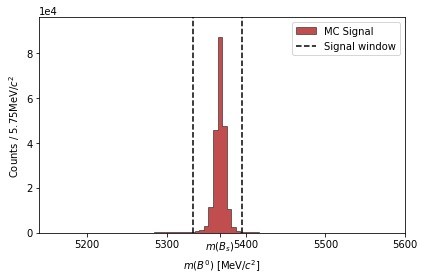

In [13]:
xr = (5140, 5600)
bins = 80

bins = np.linspace(*xr, bins+1)

centers = (bins[:-1] + bins[1:]) / 2
width = np.sum(bins[1:] - bins[:-1]) / len(centers)

fig, ax = plt.subplots(1, 1)
counts, _, _ = ax.hist(df_MC["B_FitDaughtersConst_M_flat"], bins = bins, label = "MC Signal", 
                       color = "firebrick", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled")

plt.vlines(signal_window, 0, 1.1*max(counts), linestyle = "dashed", label = "Signal window")
plt.xlabel(r"$m(B^0)$ [MeV/$c^2$]")
plt.ylabel(f"Counts / {width}" + r"MeV/$c^2$")
plt.legend()
plt.xlim(*xr)
plt.ylim(0, 1.1*max(counts))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ticks = list(ax.get_xticks()) + [m_Bs]
labels = [str(int(tick)) for tick in ticks]
labels[-1] = r"$m(B_s)$"
plt.xticks(ticks = ticks, labels = labels)
plt.xlim(*xr)
plt.tight_layout();

fig.savefig("plots/mass_signal.pdf")

Now that we have defined a signal window, lets see where it is in the data mass distribution.  

**Ex 2.2: Plot the data mass distribution with the signal window**

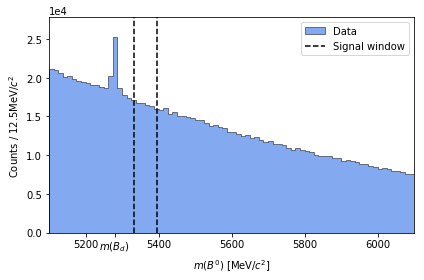

In [14]:
xr = (5100, 6100)
bins = 80

bins = np.linspace(*xr, bins+1)

centers = (bins[:-1] + bins[1:]) / 2
width = np.sum(bins[1:] - bins[:-1]) / len(centers)

fig, ax = plt.subplots(1, 1)
counts, _, _ = ax.hist(df_data["B_FitDaughtersConst_M_flat"], bins = bins, label = "Data", 
                       color = "cornflowerblue", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled")

plt.vlines(signal_window, 0, 1.1*max(counts), linestyle = "dashed", label = "Signal window")
plt.xlabel(r"$m(B^0)$ [MeV/$c^2$]")
plt.ylabel(f"Counts / {width}" + r"MeV/$c^2$")
plt.legend()
plt.xlim(*xr)
plt.ylim(0, 1.1*max(counts))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ticks = list(ax.get_xticks()) + [m_Bd]
labels = [str(int(tick)) for tick in ticks]
#labels[-2] = r"$m(B_s)$"
labels[-1] = r"$m(B_d)$"
plt.xticks(ticks = ticks, labels = labels)
plt.xlim(*xr)
plt.tight_layout();

fig.savefig("plots/mass_data.pdf")

To train the classifier, we should never use the signal window because it could bias the classifier. Instead, we need to define suitable signal and background training samples to work on.  
Our signal sample will be the signal simulation, and as background we want to choose the **upper sideband (USB)** of the $B_s$ peak (yet invisble) in the data. The USB of the $B_s$ peak contains the events with reconstructed $B_s$ masses larger than the nominal $B_s$ mass. It contains only combinatorial background and is therefore perfect for the job, since this is what we want to get rid of.  

**Ex 2.3: Select the background sample**

In [15]:
df_bckg = df_data[df_data["B_FitDaughtersConst_M_flat"] > 5400].copy()

### 2.2 Signal training sample
Our simulation algorithms are far from perfect, mainly due to imperfect theoretical physics models and our imperfect modelling of the detector to simulate responses. For example, some aspects of the decay kinematics are often imperfect in simulation and are corrected for using such weights, stored in the variable `kinematic_weights`. You should use these weights for everything from now on.

But other properties may be mis-modelled by the simulation as well. This means that even if you find the most discriminating variables now (using the`kinematic_weights`) and train a classifier with them, your classifier would only be able to classify simulation and data - instead of signal and background.

Therefore, we need to evaluate how similar simulation and data are in each variable without having $B_s$ data to compare the simulation with. And here we take advantage of the decay $B^0\to\psi(2S)K_S$. The $B^0$ decay is similar to the $B_s$ decay, especially in the kinematic variables which will be very important in the removal of combinatorial background. Additionally, the $B^0$ decay is very abundant, we can already see it by eye in the data set.

Fortunately, the sWeights `sWeights_sig` giving us pure $B^0$ events from the data sample have already been computed.
**Caution:** sWeighted data distributions are only a reliable representation of the true distribution if the variable you look at is uncorrelated to the invariant $B$ mass.

**Ex. 2.4: Plot the reconstructed invariant mass of the $B$ meson in the data set with and without sWeights**

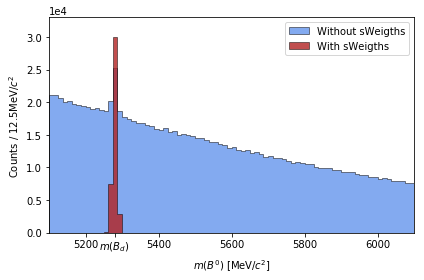

In [16]:
xr = (5100, 6100)
bins = 80

bins = np.linspace(*xr, bins+1)

centers = (bins[:-1] + bins[1:]) / 2
width = np.sum(bins[1:] - bins[:-1]) / len(centers)

fig, ax = plt.subplots(1, 1)
counts, _, _ = ax.hist(df_data["B_FitDaughtersConst_M_flat"], bins = bins, label = "Without sWeigths", 
                       color = "cornflowerblue", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled")
counts, _, _ = ax.hist(df_data["B_FitDaughtersConst_M_flat"], bins = bins, label = "With sWeigths", 
                       color = "firebrick", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled", 
                       weights = df_data["sweights_sig"])

plt.xlabel(r"$m(B^0)$ [MeV/$c^2$]")
plt.ylabel(f"Counts / {width}" + r"MeV/$c^2$")
plt.legend()
plt.xlim(*xr)
plt.ylim(0, 1.1*max(counts))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ticks = list(ax.get_xticks()) + [m_Bd]
labels = [str(int(tick)) for tick in ticks]
labels[-1] = r"$m(B_d)$"
plt.xticks(ticks = ticks, labels = labels)
plt.xlim(*xr)
plt.tight_layout();

fig.savefig("plots/mass_reweighted.pdf")

**Ex. 2.5: Compare the $B^0$ events in data with the $B^0$ simulation for each variable by eye**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Don't forget the weights in both samples.</a></h4>

In [17]:
all_vars = list(df_data.columns)
print(len(all_vars))
all_vars[:812]

863


['B_LOKI_ENERGY',
 'B_LOKI_ETA',
 'B_LOKI_PHI',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_MINIPNEXTBEST',
 'B_MINIPCHI2NEXTBEST',
 'B_ENDVERTEX_X',
 'B_ENDVERTEX_Y',
 'B_ENDVERTEX_Z',
 'B_ENDVERTEX_XERR',
 'B_ENDVERTEX_YERR',
 'B_ENDVERTEX_ZERR',
 'B_ENDVERTEX_CHI2',
 'B_OWNPV_X',
 'B_OWNPV_Y',
 'B_OWNPV_Z',
 'B_OWNPV_XERR',
 'B_OWNPV_YERR',
 'B_OWNPV_ZERR',
 'B_OWNPV_CHI2',
 'B_OWNPV_NDOF',
 'B_IP_OWNPV',
 'B_IPCHI2_OWNPV',
 'B_FD_OWNPV',
 'B_FDCHI2_OWNPV',
 'B_DIRA_OWNPV',
 'B_TOPPV_X',
 'B_TOPPV_Y',
 'B_TOPPV_Z',
 'B_TOPPV_XERR',
 'B_TOPPV_YERR',
 'B_TOPPV_ZERR',
 'B_TOPPV_CHI2',
 'B_TOPPV_NDOF',
 'B_IP_TOPPV',
 'B_IPCHI2_TOPPV',
 'B_FD_TOPPV',
 'B_FDCHI2_TOPPV',
 'B_DIRA_TOPPV',
 'B_P',
 'B_PT',
 'B_PE',
 'B_PX',
 'B_PY',
 'B_PZ',
 'B_MM',
 'B_MMERR',
 'B_M',
 'B_TAU',
 'B_TAUERR',
 'B_TAUCHI2',
 'B_LOKI_DIRA',
 'B_LOKI_DOCA',
 'B_LOKI_DOCACHI2',
 'B_LOKI_DTF_CHI2NDOF',
 'B_LOKI_DTF_CTAU',
 'B_LOKI_DTF_CTAUERR',
 'B_LOKI_DTF_CTAUERR_D2',
 'B_LOKI_DTF_CTAUS',
 'B_LOKI_DTF_C

In [18]:
def remove_entries_with_keywords(strings, keywords):
    """
    Remove entries from a list of strings that contain any of the specified keywords.
    
    Parameters:
    strings (list of str): The list of strings to filter.
    keywords (list of str): The keywords to look for in the strings.
    
    Returns:
    list of str: The filtered list of strings.
    """
    filtered_strings = []
    
    for string in strings:
        if not any(keyword in string for keyword in keywords):
            filtered_strings.append(string)
    
    return filtered_strings

In [19]:
df_MC_ctrl.columns

Index(['B_LOKI_ENERGY', 'B_LOKI_ETA', 'B_LOKI_PHI', 'B_Vtx_Chi2NDOF',
       'B_MINIP', 'B_MINIPCHI2', 'B_MINIPNEXTBEST', 'B_MINIPCHI2NEXTBEST',
       'B_ENDVERTEX_X', 'B_ENDVERTEX_Y',
       ...
       'L0MuonDecision', 'L0DiMuonDecision', 'L0HadronDecision',
       'L0ElectronDecision', 'L0PhotonDecision', 'L0nSelections',
       'MaxRoutingBits', 'year', 'rndm_Number', 'kinematic_weights'],
      dtype='object', length=896)

In [20]:
selected_vars = [ # some vars that could be useful, tbh I have no clue what vars we are supposed to look at here
    'B_LOKI_ENERGY',
    'B_LOKI_ETA',
    'B_LOKI_PHI',
    'B_Vtx_Chi2NDOF',
    'B_MINIP',
    'B_MINIPCHI2',
    'B_MINIPNEXTBEST',
    'B_MINIPCHI2NEXTBEST',
    'B_ENDVERTEX_CHI2',
    'B_OWNPV_CHI2',
    'B_IP_OWNPV',
    'B_IPCHI2_OWNPV',
    'B_FD_OWNPV',
    'B_FDCHI2_OWNPV',
    'B_DIRA_OWNPV',
    'B_P',
    'B_PT',
    'B_TAU',
    'B_LOKI_DOCA',
    'B_FitDaughtersConst_KS0_decayLength_flat',
    'B_FitJpsiConst_KS0_ctau_flat',
    'B_FitPVConst_decayLength_flat',
    'psi_2S_MINIP',
    'psi_2S_MINIPCHI2',
    'psi_2S_OWNPV_CHI2',
    'psi_2S_IP_OWNPV',
    'psi_2S_IPCHI2_OWNPV',
    'psi_2S_FD_OWNPV',
    'psi_2S_FDCHI2_OWNPV',
    'psi_2S_DIRA_OWNPV',
    'muplus_MINIP',
    'muminus_MINIP',
    'KS0_Vtx_Chi2NDOF',
    'KS0_MINIP',
]
len(selected_vars)

34

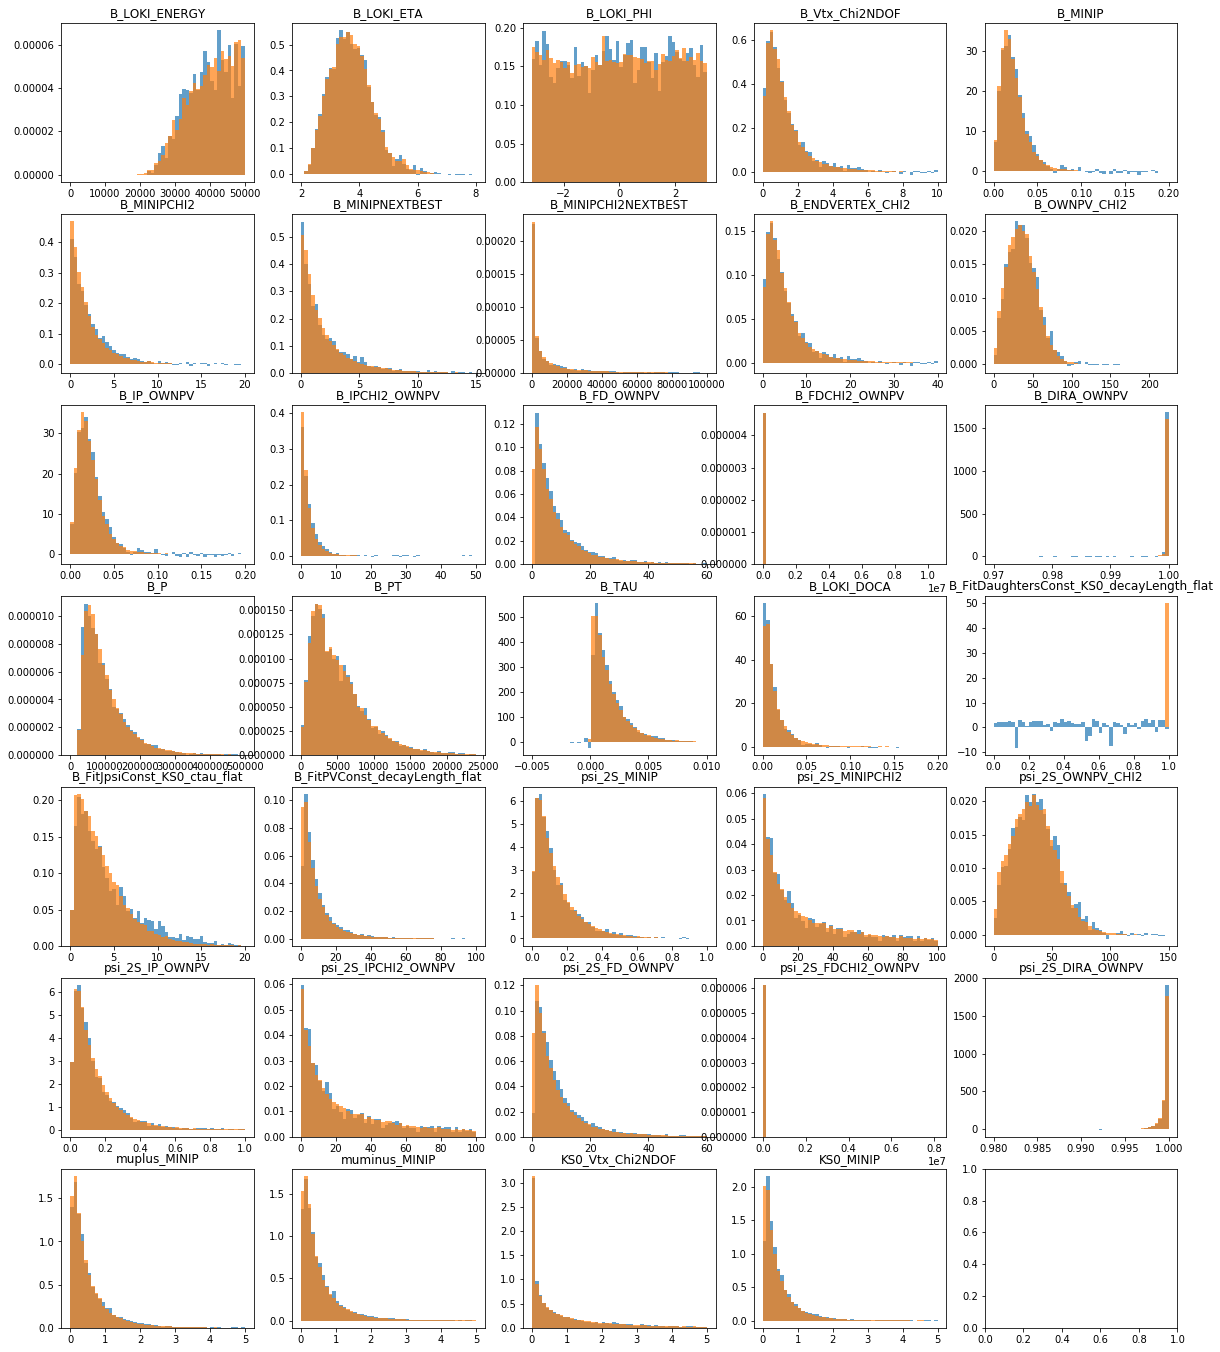

In [21]:
fig, ax = plt.subplots(7, 5, figsize = (20, 24))
n_bins = 50
ranges = [(0, 50000), (2, 8), None, None, (0, 0.2), (0, 20), (0, 15), (0, 100000), None, None, (0, 0.2), (0, 50), (0, 60),
         None, (0.97, 1), (0, 500000), (0, 24000), (-0.005, 0.01), (0.0, 0.2), (0, 1), (0, 20), (0, 100), (0, 1), (0, 100),
         (0, 150), (0, 1), (0, 100), (0, 60), None, (0.98, 1), (0, 5), (0, 5), (0, 5), (0, 5)]
for i in range(34):
    ax_temp = ax[i//5, i%5]
    _, bins, _ = ax_temp.hist(df_data[selected_vars[i]], weights = df_data["sweights_sig"], 
                              density = True, alpha = .7, bins = n_bins, range = ranges[i])
    ax_temp.hist(df_MC_ctrl[selected_vars[i]], weights = df_MC_ctrl["kinematic_weights"], 
                 density = True, alpha = .7, bins = bins)
    ax_temp.set_title(selected_vars[i])

## 3. Feature selection
Now we want to find a set of variables that are most suitable to identify the $B_s$ events in the data sample. To this end, the variables need to have two properties:
 1. Reasonable agreement between data and simulation (otherwise the classifier only learns to distinguish data from simulation instead of signal from background).
 2. Strong discrimination between signal (simulation) and background (USB).
 3. Uncorrelated to the invariant mass of the $B_s/B^0$ candidate (otherwise the decisions regarding 1. made on the control channel using sWeights may be wrong AND the fit to the $B_s$ invariant mass in the end may be biased).

The eventually chosen most suitable variables are called features.

**This section provides a step-by-step guide to feature selection which is perfectly fine to use. But of course you are encouraged to combine all or parts of the exercises below. There is no single best solution.**

First, we identify the variables that are well modelled in the simulation. This is similar to Ex. 2.5 but instead of comparing distributions by-eye, you should choose a more objective -- read "quantitative" -- measure.

**Ex 3.1: Determine a metric to quantify the similarity between $B^0$ simulation and $B^0$ data. Use this metric to identify variables that are not suitable for the classification because they are mis-modelled in simulation.**

In [22]:
vars = all_vars[:812]
vars

['B_LOKI_ENERGY',
 'B_LOKI_ETA',
 'B_LOKI_PHI',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_MINIPNEXTBEST',
 'B_MINIPCHI2NEXTBEST',
 'B_ENDVERTEX_X',
 'B_ENDVERTEX_Y',
 'B_ENDVERTEX_Z',
 'B_ENDVERTEX_XERR',
 'B_ENDVERTEX_YERR',
 'B_ENDVERTEX_ZERR',
 'B_ENDVERTEX_CHI2',
 'B_OWNPV_X',
 'B_OWNPV_Y',
 'B_OWNPV_Z',
 'B_OWNPV_XERR',
 'B_OWNPV_YERR',
 'B_OWNPV_ZERR',
 'B_OWNPV_CHI2',
 'B_OWNPV_NDOF',
 'B_IP_OWNPV',
 'B_IPCHI2_OWNPV',
 'B_FD_OWNPV',
 'B_FDCHI2_OWNPV',
 'B_DIRA_OWNPV',
 'B_TOPPV_X',
 'B_TOPPV_Y',
 'B_TOPPV_Z',
 'B_TOPPV_XERR',
 'B_TOPPV_YERR',
 'B_TOPPV_ZERR',
 'B_TOPPV_CHI2',
 'B_TOPPV_NDOF',
 'B_IP_TOPPV',
 'B_IPCHI2_TOPPV',
 'B_FD_TOPPV',
 'B_FDCHI2_TOPPV',
 'B_DIRA_TOPPV',
 'B_P',
 'B_PT',
 'B_PE',
 'B_PX',
 'B_PY',
 'B_PZ',
 'B_MM',
 'B_MMERR',
 'B_M',
 'B_TAU',
 'B_TAUERR',
 'B_TAUCHI2',
 'B_LOKI_DIRA',
 'B_LOKI_DOCA',
 'B_LOKI_DOCACHI2',
 'B_LOKI_DTF_CHI2NDOF',
 'B_LOKI_DTF_CTAU',
 'B_LOKI_DTF_CTAUERR',
 'B_LOKI_DTF_CTAUERR_D2',
 'B_LOKI_DTF_CTAUS',
 'B_LOKI_DTF_C

In [23]:
vars = remove_entries_with_keywords(vars, ["ERR", "Err", "Decision", "status", "Rich", "has", "Key", "_X", "_Y", "_Z"
                                          ,"_PX", "_PY", "_PZ", "UTID", "FirstMeasurement", "History", "L0Global", 
                                          "isMuon"])
len(vars)

398

### Remove entries that are too correlated to invariant mass

In [24]:
corr = []
for var in vars:
    c = df_data["B_FitDaughtersConst_M_flat"].corr(df_data[var])
    corr.append(c)

In [25]:
vars = list(np.array(vars)[np.array(corr) < 0.3])

In [26]:
len(vars)

390

### Define test statistic (ks test)

In [27]:
def weighted_ks_test(data1, data2, weights1, weights2):
    # Sort the data and weights
    data1_sorted_indices = np.argsort(data1)
    data2_sorted_indices = np.argsort(data2)
    
    data1_sorted = np.array(data1)[data1_sorted_indices]
    data2_sorted = np.array(data2)[data2_sorted_indices]
    
    weights1_sorted = np.array(weights1)[data1_sorted_indices]
    weights2_sorted = np.array(weights2)[data2_sorted_indices]
    
    # Compute the cumulative sums of the weights
    cdf1 = np.cumsum(weights1_sorted) / np.sum(weights1_sorted)
    cdf2 = np.cumsum(weights2_sorted) / np.sum(weights2_sorted)
    
    # Calculate the CDF values for all unique points in both datasets
    all_data = np.concatenate([data1_sorted, data2_sorted])
    all_unique_data = np.unique(all_data)
    
    cdf1_values = np.interp(all_unique_data, data1_sorted, cdf1, left=0, right=1)
    cdf2_values = np.interp(all_unique_data, data2_sorted, cdf2, left=0, right=1)
    
    # Compute the KS statistic
    ks_statistic = np.max(np.abs(cdf1_values - cdf2_values))
    
    return ks_statistic

In [28]:
from tqdm import tqdm

In [29]:
results = []
for var in tqdm(vars):
    result = weighted_ks_test(df_data[var], df_MC_ctrl[var], df_data["sweights_sig"], df_MC_ctrl["kinematic_weights"])
    results.append([var, result])

100%|██████████| 390/390 [01:53<00:00,  4.62it/s]


In [30]:
np.array(results)[np.argsort(np.array(results)[:,1])]

array([['B_FitJpsiPVConst_nIter_flat', '0.0013858577323747623'],
       ['B_FitwithoutConst_nIter_flat', '0.006023538849753152'],
       ['B_FitJpsiConst_nIter_flat', '0.007749856944072486'],
       ['B_PT', '0.00792110153286471'],
       ['muminus_TRACK_nVeloRHits', '0.009038073924078849'],
       ['B_FitPVConst_nIter_flat', '0.00923767154109767'],
       ['B_LOKI_ETA', '0.00998942324834251'],
       ['muminus_LOKI_PHI', '0.010468418268017476'],
       ['muminus_TRACK_nVeloPhiHits', '0.010492234341913376'],
       ['muminus_TRACK_nVeloHits', '0.010593866612928271'],
       ['B_LOKI_PHI', '0.010846407274425263'],
       ['piminus_ORIVX_CHI2', '0.010855506257340747'],
       ['KS0_ENDVERTEX_CHI2', '0.010855506257340747'],
       ['piplus_ORIVX_CHI2', '0.010855506257340747'],
       ['KS0_Vtx_Chi2NDOF', '0.010855506257340747'],
       ['muplus_TRACK_nVeloRHits', '0.012282740013396937'],
       ['muplus_TRACK_nVeloPhiHits', '0.013093984447341445'],
       ['piplus_TRACK_nVeloRHits', '0.01

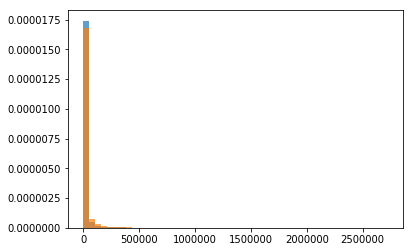

In [31]:
x = 'psi_2S_MINIPCHI2NEXTBEST'

_, bins, _ = plt.hist(df_data[x], weights = df_data["sweights_sig"], 
                              density = True, alpha = .7, bins = n_bins)
plt.hist(df_MC_ctrl[x], weights = df_MC_ctrl["kinematic_weights"], 
                 density = True, alpha = .7, bins = bins);

In [32]:
alpha = 0.95 # significance of the test

K_alpha = np.sqrt(np.log(2/alpha)/alpha)
print(K_alpha)
n_1 = np.sum(df_data["sweights_sig"])
n_2 = np.sum(df_MC_ctrl["kinematic_weights"])
n = np.sqrt(n_1*n_2/(n_1+n_2))
# reject test if d > K_alpha/n
print(f"Reject if d > {K_alpha/n}.")

0.8852240126523406
Reject if d > 0.009022288593733782.


Would leave to few variables :/
### $\rightarrow$ Reject if d > 0.05

In [33]:
vars = np.extract(np.array(results)[:,1].astype(float) < 0.05, np.array(results)[:,0])
len(vars)

200

Great, we are left with all variables that could help to discriminate between signal and background. The second step of feature selection is identifying the discriminatory power of each remaining variable.

**Ex. 3.2: Define a metric to quantify discriminating power and choose the best features to use in a classification algorithm.**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">This is very similar to Ex. 3.1.</a></h4>

In [34]:
results = []
for var in tqdm(vars):
    result = weighted_ks_test(df_bckg[var], df_MC[var], np.ones(len(df_bckg)), df_MC["kinematic_weights"])
    results.append([var, result])

100%|██████████| 200/200 [00:36<00:00,  5.48it/s]


In [35]:
np.array(results)[np.argsort(np.array(results)[:,1])]

array([['B_LOKI_PHI', '0.00597575277891807'],
       ['psi_2S_LOKI_PHI', '0.006966249970753374'],
       ['muminus_LOKI_PHI', '0.007458127387392877'],
       ['piplus_ProbNNmu', '0.010011058423874841'],
       ['muplus_LOKI_PHI', '0.010528401753732486'],
       ['piminus_ProbNNmu', '0.013329878073908619'],
       ['piminus_LOKI_PHI', '0.013894821191218654'],
       ['piplus_LOKI_PHI', '0.014970003245277308'],
       ['piplus_M', '0.016459501247176545'],
       ['KS0_LOKI_PHI', '0.017245867518600466'],
       ['piminus_M', '0.018893932317350814'],
       ['muplus_TRACK_nTTHits', '0.029678990215816534'],
       ['muminus_TRACK_nTTHits', '0.03226300215182404'],
       ['muplus_PIDe', '0.0336244363094787'],
       ['muminus_PIDe', '0.037648289923327916'],
       ['B_FitPVConst_nIter_flat', '0.03838306895139576'],
       ['B_FitwithoutConst_nIter_flat', '0.040738488732075306'],
       ['KS0_Vtx_Chi2NDOF', '0.04103292657589391'],
       ['piplus_ORIVX_CHI2', '0.04103292657589391'],
       ['

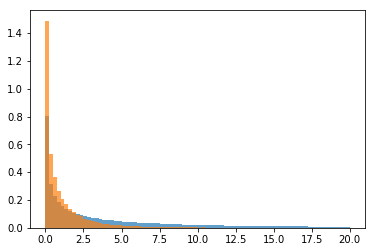

In [36]:
x = 'psi_2S_Vtx_Chi2NDOF'
xr = None
n_bins = 80
_, bins, _ = plt.hist(df_bckg[x], density = True, alpha = .7, bins = n_bins, range = xr)
plt.hist(df_MC[x], 
         weights = df_MC["kinematic_weights"], 
         density = True, alpha = .7, bins = bins);

### Select variables where signal and background differ a lot
d > 0.20

In [37]:
vars = np.extract(np.array(results)[:,1].astype(float) > 0.20, np.array(results)[:,0])
len(vars)

94

In [38]:
vars

array(['B_LOKI_ETA', 'B_Vtx_Chi2NDOF', 'B_MINIP', 'B_MINIPCHI2',
       'B_ENDVERTEX_CHI2', 'B_OWNPV_CHI2', 'B_OWNPV_NDOF', 'B_IP_OWNPV',
       'B_IPCHI2_OWNPV', 'B_FDCHI2_OWNPV', 'B_TOPPV_CHI2', 'B_TOPPV_NDOF',
       'B_IP_TOPPV', 'B_IPCHI2_TOPPV', 'B_FDCHI2_TOPPV', 'B_PT',
       'B_TAUCHI2', 'B_LOKI_DTF_CHI2NDOF', 'B_LOKI_DTF_VCHI2NDOF',
       'B_LOKI_FDCHI2', 'B_FitDaughtersConst_KS0_M_flat',
       'B_FitDaughtersConst_chi2_flat',
       'B_FitDaughtersConst_psi_2S_M_flat',
       'B_FitDaughtersPVConst_KS0_M_flat',
       'B_FitDaughtersPVConst_chi2_flat',
       'B_FitDaughtersPVConst_psi_2S_M_flat', 'B_FitJpsiConst_chi2_flat',
       'B_FitJpsiConst_psi_2S_M_flat', 'B_FitJpsiPVConst_chi2_flat',
       'B_FitJpsiPVConst_psi_2S_M_flat', 'B_FitPVConst_chi2_flat',
       'B_FitPVConst_psi_2S_M_flat', 'B_FitwithoutConst_chi2_flat',
       'B_FitwithoutConst_psi_2S_M_flat', 'psi_2S_Vtx_Chi2NDOF',
       'psi_2S_ENDVERTEX_CHI2', 'psi_2S_OWNPV_CHI2', 'psi_2S_OWNPV_NDOF',
       'psi

Now, you should have a set of variables that is well simulated and provides good discrimination between signal and background. Before we move on, you should check whether these features are uncorrelated to the invariant mass of the $B_s$ candidate.

**Ex. 3.3: Compute the correlation between your features and the invariant $B_s$ mass and remove features from your set if they are too correlated.**

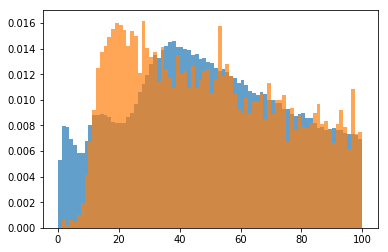

In [39]:
x = 'B_LOKI_FDCHI2'
_, bins, _ = plt.hist(df_bckg[x], density = True, alpha = .7, bins = n_bins, range = (0, 100))
plt.hist(df_MC[x], 
         weights = df_MC["kinematic_weights"], 
         density = True, alpha = .7, bins = bins);

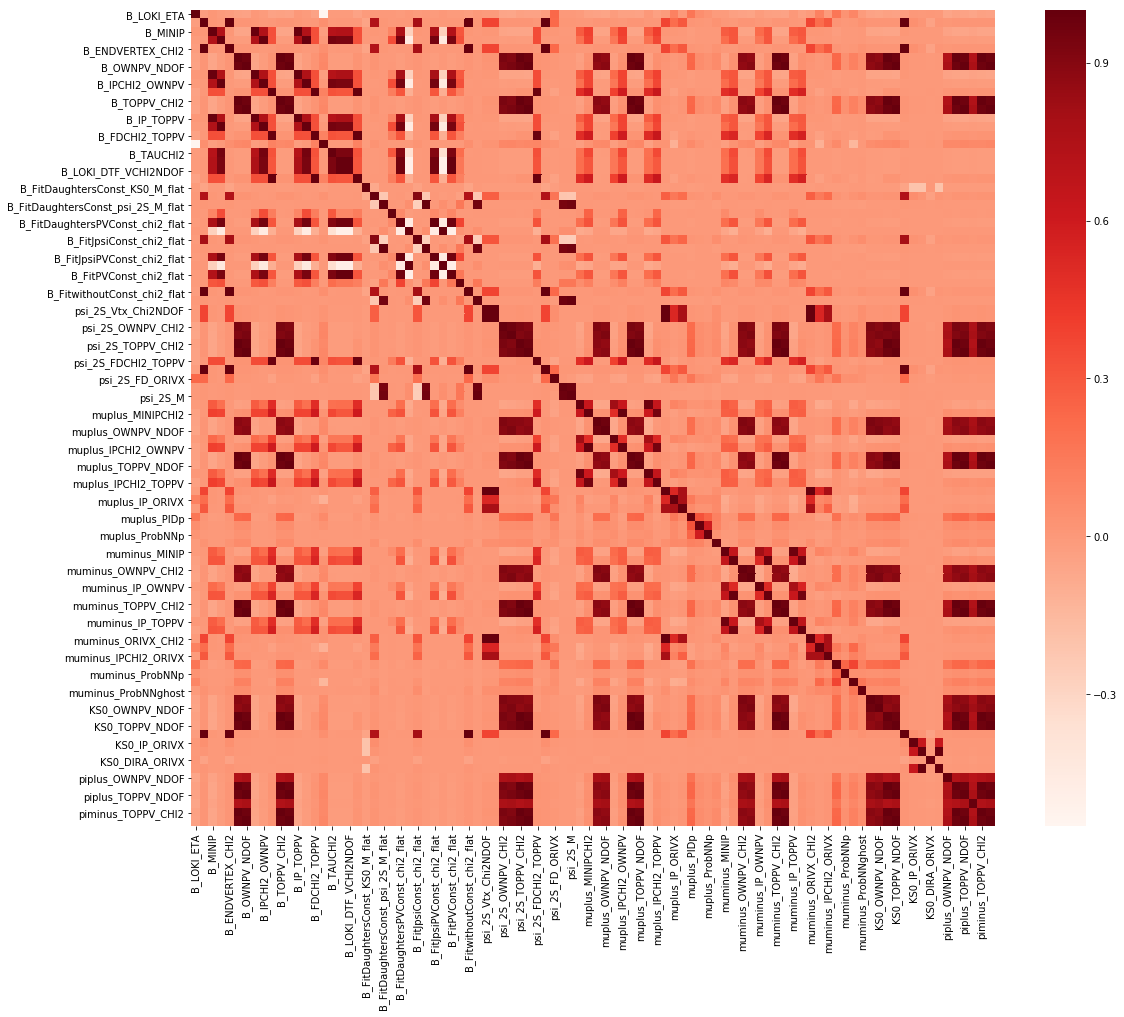

In [40]:
import seaborn as sns

plt.figure(figsize=(18, 15))
cor = df_MC[vars].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

### List of variables to remove (too high correlation, checking distributions by eye)

In [41]:
dublicates = ["B_ENDVERTEX_CHI2", "KS0_ORIVX_CHI2", "B_FitwithoutConst_chi2_flat", "psi_2S_ORIVX_CHI2", 
              "B_IP_OWNPV", "B_IP_TOPPV", "B_IPCHI2_OWNPV", "B_IPCHI2_TOPPV", "B_TAUCHI2", "B_LOKI_DTF_CHI2NDOF",
              "B_LOKI_DTF_VCHI2NDOF", "B_FitDaughtersPVConst_chi2_flat", "B_FitJpsiPVConst_chi2_flat", "B_FitPVConst_chi2_flat",
              "B_OWNPV_NDOF", "B_TOPPV_CHI2", "B_TOPPV_NDOF", "psi_2S_OWNPV_CHI2", "psi_2S_OWNPV_NDOF", "psi_2S_TOPPV_CHI2",
              "psi_2S_TOPPV_NDOF", "muplus_TOPPV_CHI2", "muplus_TOPPV_NDOF", "muminus_TOPPV_CHI2", "muminus_TOPPV_NDOF",
              "KS0_TOPPV_CHI2", "KS0_TOPPV_NDOF", "piplus_TOPPV_CHI2", "piplus_TOPPV_NDOF", "piminus_TOPPV_CHI2", 
              "piminus_TOPPV_NDOF", "B_FDCHI2_TOPPV", "B_LOKI_FDCHI2", "psi_2S_FDCHI2_TOPPV", "B_FitJpsiConst_psi_2S_M_flat",
              "B_FitwithoutConst_psi_2S_M_flat", "psi_2S_MM", "psi_2S_M", "psi_2S_ENDVERTEX_CHI2", "muplus_ORIVX_CHI2",
              "muminus_ORIVX_CHI2", "muplus_IP_TOPPV", "muplus_IPCHI2_OWNPV", "muplus_IPCHI2_TOPPV", "muplus_OWNPV_NDOF",
             "muminus_OWNPV_CHI2", "KS0_OWNPV_CHI2", "KS0_OWNPV_NDOF", "muminus_IP_TOPPV", "muminus_IPCHI2_OWNPV", 
             "muminus_IPCHI2_TOPPV", "KS0_TAUCHI2", "muplus_OWNPV_CHI2", "muminus_OWNPV_NDOF", "B_FitJpsiConst_chi2_flat",
             "muplus_IP_OWNPV", "muminus_IP_OWNPV", 
              # the following are optional (correlations < 0.8)
              #"B_FitDaughtersConst_chi2_flat", "B_MINIPCHI2", "piplus_OWNPV_NDOF", "piminus_OWNPV_NDOF",
              #"muplus_MINIPCHI2", "muminus_MINIPCHI2",
              # from looking at distributions
              "B_FitDaughtersPVConst_KS0_M_flat", "B_FitDaughtersConst_KS0_M_flat", "KS0_IP_ORIVX", "KS0_DIRA_ORIVX",
              "ProbNN", "psi_2S_Vtx_Chi2NDOF", "KS0_IPCHI2_ORIVX","muplus_IPCHI2_ORIVX", "muminus_IPCHI2_ORIVX", 
              "psi_2S_FD_ORIVX"
             ]

vars = remove_entries_with_keywords(vars, dublicates)
len(vars)

18

In [42]:
pd.set_option("max_rows", 15)
pd.set_option("max_columns", 10)
cor

,B_LOKI_ETA,B_Vtx_Chi2NDOF,B_MINIP,B_MINIPCHI2,B_ENDVERTEX_CHI2,...,piplus_TOPPV_CHI2,piplus_TOPPV_NDOF,piminus_OWNPV_NDOF,piminus_TOPPV_CHI2,piminus_TOPPV_NDOF
B_LOKI_ETA,1.000000,-0.018571,0.007175,-0.009062,-0.018571,...,-0.039810,-0.045546,-0.055700,-0.039810,-0.045546
B_Vtx_Chi2NDOF,-0.018571,1.000000,0.012938,-0.000459,1.000000,...,0.016938,0.016936,0.015799,0.016938,0.016936
B_MINIP,0.007175,0.012938,1.000000,0.741416,0.012938,...,-0.054629,-0.057395,-0.044872,-0.054629,-0.057395
B_MINIPCHI2,-0.009062,-0.000459,0.741416,1.000000,-0.000459,...,-0.012293,-0.011724,-0.006153,-0.012293,-0.011724
B_ENDVERTEX_CHI2,-0.018571,1.000000,0.012938,-0.000459,1.000000,...,0.016938,0.016936,0.015799,0.016938,0.016936
B_OWNPV_CHI2,-0.039810,0.016938,-0.054629,-0.012293,0.016938,...,1.000000,0.972184,0.744172,1.000000,0.972184
B_OWNPV_NDOF,-0.045546,0.016936,-0.057395,-0.011724,0.016936,...,0.972184,1.000000,0.772538,0.972184,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
KS0_TAUCHI2,-0.000293,0.018549,-0.000055,-0.000147,0.018549,...,0.001920,0.002029,0.000601,0.001920,0.002029
piplus_OWNPV_NDOF,-0.055908,0.013198,-0.044856,-0.005958,0.013198,...,0.743497,0.771738,0.709113,0.743497,0.771738


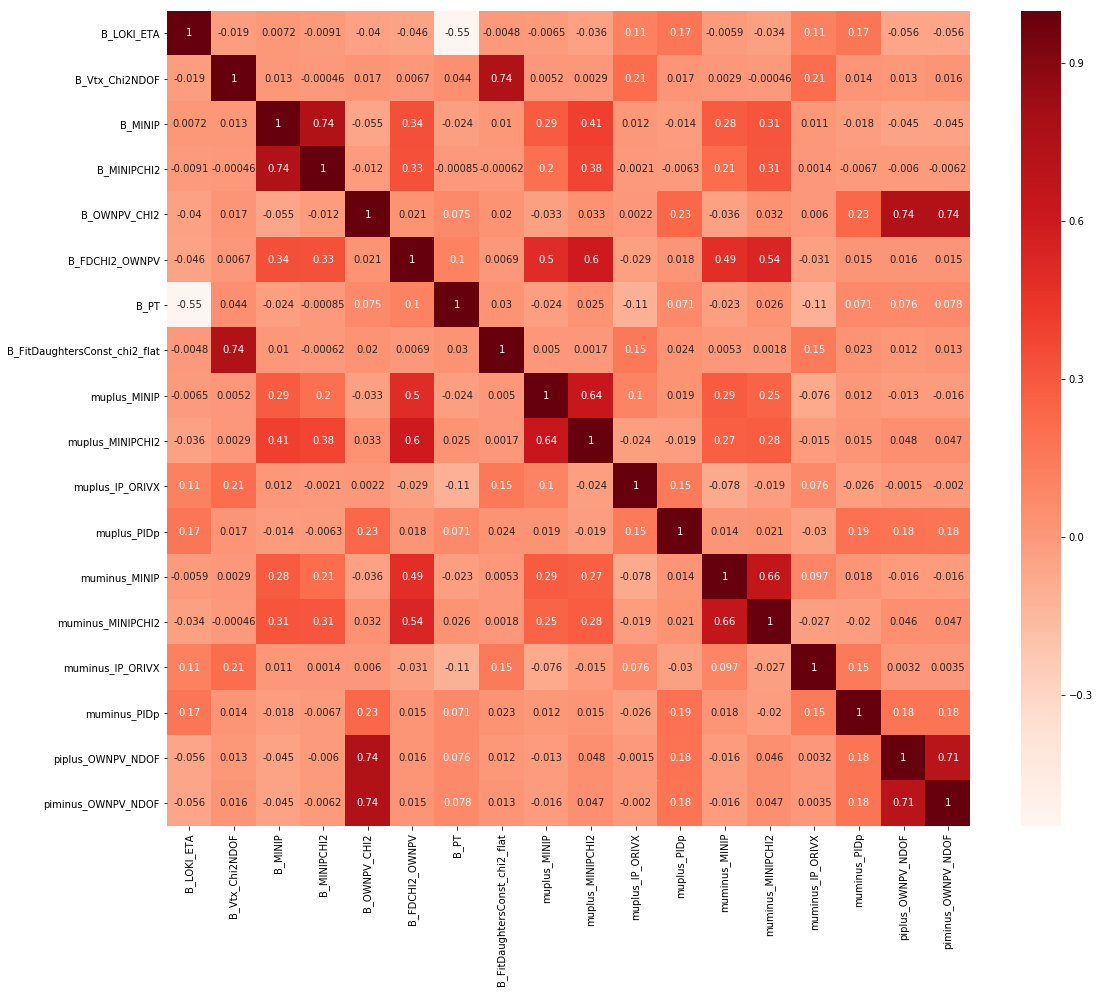

In [43]:
import seaborn as sns

fig = plt.figure(figsize=(18, 15))
cor = df_MC[vars].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

fig.savefig("plots/correlations.pdf")

### Check leftover variables again via plot

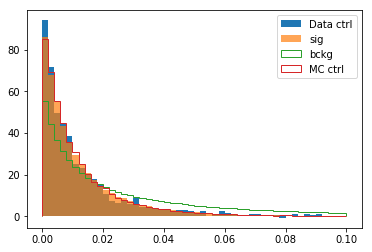

In [44]:
x = "muplus_IP_ORIVX"
_, bins, _ = plt.hist(df_data[x], bins = 50, weights = df_data["sweights_sig"], density = True, range = (0,0.1),
                     label = "Data ctrl");
plt.hist(df_MC[x], weights = df_MC["kinematic_weights"], density = True, alpha = .7, bins = bins, label = "sig")
plt.hist(df_data[x], density = True, bins = bins, histtype = "step", label = "bckg")
plt.hist(df_MC_ctrl[x], weights = df_MC_ctrl["kinematic_weights"], density = True, bins = bins,
                histtype = "step", label = "MC ctrl");
plt.legend();

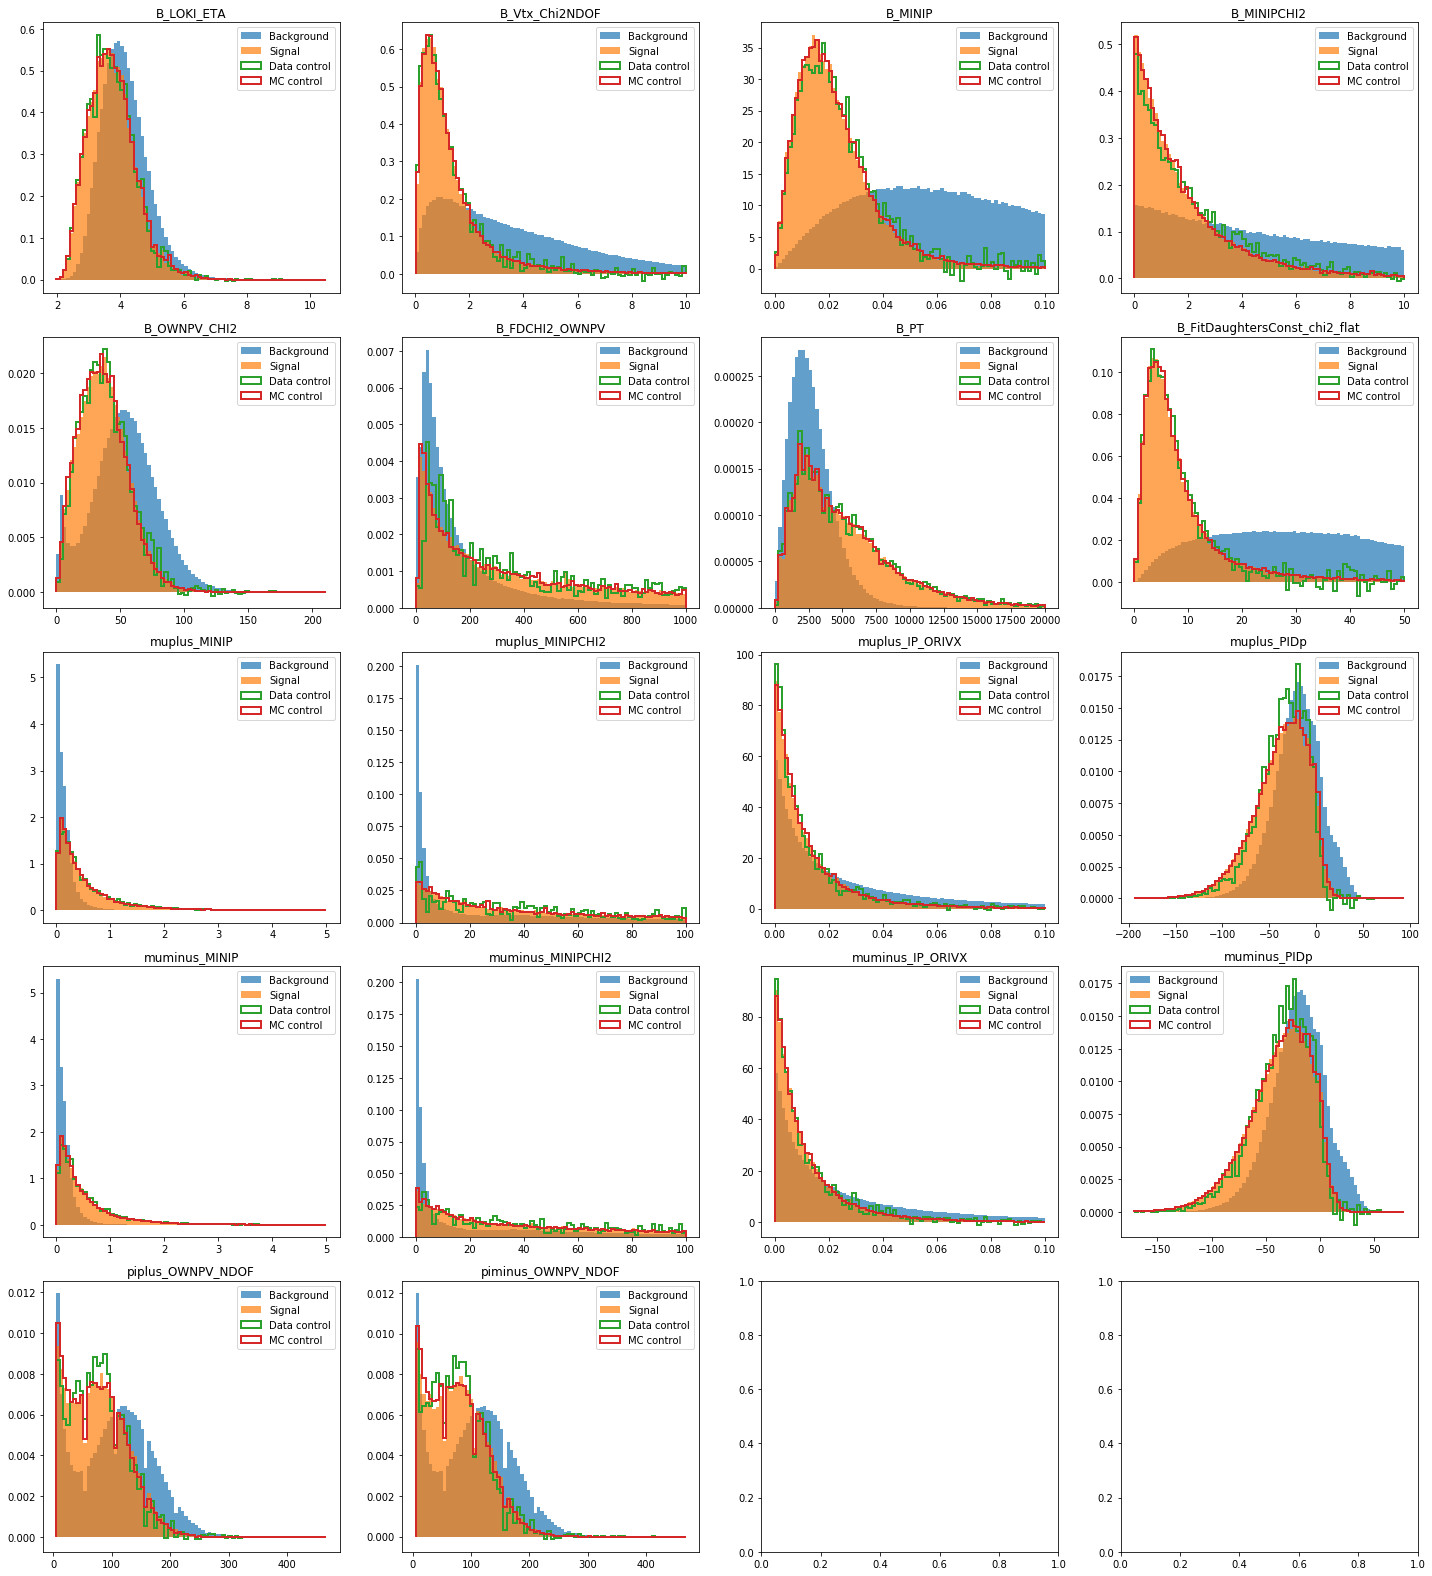

In [45]:
fig, ax = plt.subplots(5, 4, figsize = (20, 22))
n_bins = 80
ranges = [None, None, (0, 0.1), (0, 10), None, (0, 1000), (0, 20000), None, (0, 5), (0, 100), (0,0.1), None, 
          (0, 5), (0, 100), (0,0.1), None, None, None]
for i in range(len(vars)):
    ax_temp = ax[i//4, i%4]
    _, bins, _ = ax_temp.hist(df_bckg[vars[i]], density = True, alpha = .7, bins = n_bins, range = ranges[i], 
                              label = "Background")
    ax_temp.hist(df_MC[vars[i]], weights = df_MC["kinematic_weights"], density = True, alpha = .7, bins = bins, 
                 label = "Signal")
    ax_temp.hist(df_data[vars[i]], density = True, bins = bins, weights = df_data["sweights_sig"], histtype = "step", 
                 label = "Data control", lw = 2)
    ax_temp.hist(df_MC_ctrl[vars[i]], weights = df_MC_ctrl["kinematic_weights"], density = True, bins = bins,
                histtype = "step", label = "MC control", lw = 2)
    ax_temp.set_title(vars[i])
    ax_temp.legend()
plt.tight_layout()

fig.savefig("plots/all_variables.pdf")

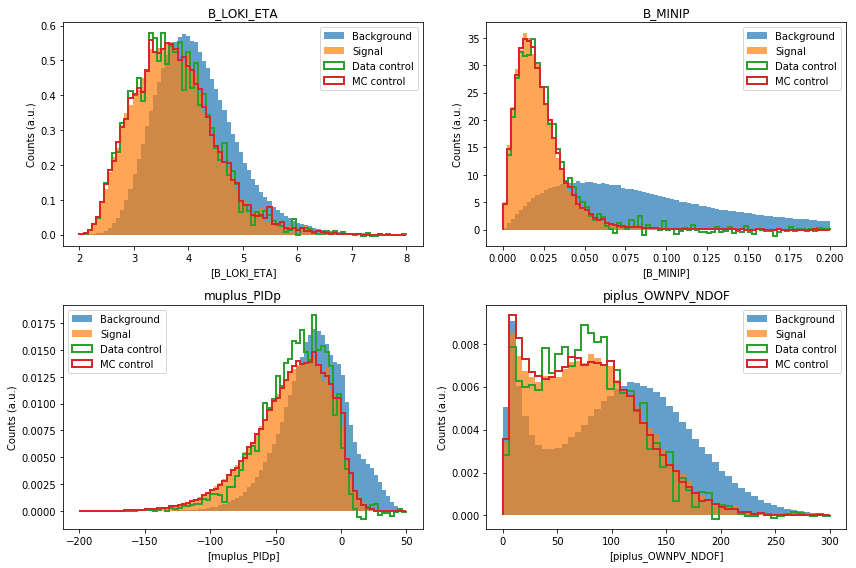

In [46]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))
v = ["B_LOKI_ETA", "B_MINIP", "muplus_PIDp", "piplus_OWNPV_NDOF"]
ranges = [(2, 8), (0, 0.2), (-200, 50), (0, 300)]
n_bins = [80, 80, 80, 50]

for i in range(4):
    ax_temp = ax[i//2, i%2]
    _, bins, _ = ax_temp.hist(df_bckg[v[i]], density = True, alpha = .7, bins = n_bins[i], range = ranges[i], 
                              label = "Background")
    ax_temp.hist(df_MC[v[i]], weights = df_MC["kinematic_weights"], density = True, alpha = .7, bins = bins, 
                  label = "Signal")
    ax_temp.hist(df_data[v[i]], density = True, bins = bins, weights = df_data["sweights_sig"], histtype = "step", 
                 label = "Data control", lw = 2)
    ax_temp.hist(df_MC_ctrl[v[i]], weights = df_MC_ctrl["kinematic_weights"], density = True, bins = bins,
                histtype = "step", label = "MC control", lw = 2)
    ax_temp.set_title(v[i])
    ax_temp.set_ylabel("Counts (a.u.)")
    ax_temp.set_xlabel(f"[{v[i]}]")
    ax_temp.legend()

plt.tight_layout()
fig.savefig("plots/4variables.pdf")

In [47]:
vars

['B_LOKI_ETA',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_OWNPV_CHI2',
 'B_FDCHI2_OWNPV',
 'B_PT',
 'B_FitDaughtersConst_chi2_flat',
 'muplus_MINIP',
 'muplus_MINIPCHI2',
 'muplus_IP_ORIVX',
 'muplus_PIDp',
 'muminus_MINIP',
 'muminus_MINIPCHI2',
 'muminus_IP_ORIVX',
 'muminus_PIDp',
 'piplus_OWNPV_NDOF',
 'piminus_OWNPV_NDOF']

## 4. Training a classification algorithm!

Now we have everything we need to train our classification algorithm. Awesome!

**Again, this section is a rather close guide to training a BDT. As before, feel free to ignore the exercises and define a classification algorithm deviating from the help provided. If you are feeling especially curious, try out other binary classification algorithms too.**

I suggest to use the [XGBoost](https://github.com/dmlc/xgboost) implementation of a [Boosted](https://en.wikipedia.org/wiki/Gradient_boosting) [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) for starters.

A BDT is a [supervised learning algorithm](https://en.wikipedia.org/wiki/Supervised_learning). This means that it needs to know to which category its input truely belongs. Therefore, we need to define labels for each event. The proposed implementation of a BDT takes an array of training samples and a list containing the corresponding label. 

**Ex 4.1: Define training sample and labels**

In [48]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

def eval_clf(clf, X_test, y_test, label = None, cmap = "Blues_r"):
    
    if not isinstance(clf, list):
        clf = [clf]
    
    fig = plt.figure(figsize=(12, len(clf)*5))
    grid = fig.add_gridspec(nrows =len(clf), ncols= 2)

    for clf, id in zip(clf, range(len(clf))):
        preds_proba = clf.predict_proba(X_test)
        preds = clf.predict(X_test)
        fpr, tpr, t = roc_curve(y_test, preds_proba[:,1])

        ax = fig.add_subplot(grid[id, 0])
        
        if label != None:
            if not isinstance(label, list):
                label = [label]
            ax.set_title(label[id])

        sc = ax.scatter(fpr, tpr, c=t, cmap=cmap, s=50)
        plt.colorbar(sc, label='Decision Threshold', ax = ax)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate');
        ax.text(0.5, 0.90, f"AUC:      ${roc_auc_score(y_test, preds_proba[:,1]):.4f}$")
        ax.text(0.5, 0.82, f"Accuracy: ${accuracy_score(y_test, preds):.4f}$");
        ax.text(0.5, 0.74, f"Recall:   ${recall_score(y_test, preds):.4f}$");
        ax.text(0.5, 0.66, f"F1:       ${f1_score(y_test, preds):.4f}$");
        if label != None:
            print(label[id]) 
        print("roc_auc score:  ", roc_auc_score(y_test, preds_proba[:,1]))
        print("Accuracy:       ", accuracy_score(y_test, preds))
        print("Recall:         ", recall_score(y_test, preds))
        print("\n")

        cm = confusion_matrix(y_test, preds)

        subax = fig.add_subplot(grid[id, 1])

        vmin = cm.min()
        vmax = cm.max()

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=["background", "signal"],
            yticklabels=["background", "signal"],
            ax=subax,
            vmin=vmin,
            vmax=vmax,
            #annot_kws={"size": 24},
        )
        subax.set_ylabel("Actual")
        subax.set_xlabel("Predicted") 
        subax.set_title("Confusion Matrix")
    return fig
            
def roc_auc_plot(clf, X_test, y_test, label = None, cmap ="Blues_r"):
    fig, ax = plt.subplots(1,1)
    preds_proba = clf.predict_proba(X_test)
    preds = clf.predict(X_test)
    fpr, tpr, t = roc_curve(y_test, preds_proba[:,1])
    if label != None:
        ax.set_title(label)
    ax.plot([0,1.5], [0,1.5], color = "black", ls = "dashed")
    sc = ax.scatter(fpr, tpr, c=t, cmap=cmap, s=30)
    plt.colorbar(sc, label='Decision Threshold', ax = ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.02])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate');
    ax.text(0.5, 0.90, f"AUC:      ${roc_auc_score(y_test, preds_proba[:,1]):.4f}$")
    ax.text(0.5, 0.82, f"Accuracy: ${accuracy_score(y_test, preds):.4f}$");
    return fig

There is way more entries in our background sample than in the signal simulation. If these numbers are too unbalanced, classification algorithms may run into problems. Consider for instance a training set with 99% background. By simply classifiying the entire sample as background, the algorithm achieves 99% accuracy. That's not very useful.
Therefore, we assign a weight to each background event to make them "less important" in the training, while still taking advantage of the full backround sample.

**Ex 4.2: Define suitable weights for the background sample**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">50/50 is never a bad choice.</a></h4>

In [49]:
print(len(df_bckg), np.sum(df_MC["kinematic_weights"]))

637410 155804.92619980156


In [50]:
df_bckg["weights"] = 155805/637410*np.ones(len(df_bckg), dtype = float)
df_MC["weights"] = df_MC["kinematic_weights"]

data = pd.concat((df_bckg, df_MC), sort = False)
label = np.concatenate((np.zeros(len(df_bckg)), np.ones(len(df_MC))))

In [51]:
np.sum(df_bckg["weights"])

155804.99999999983

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=.2, random_state=42)

If you choose to use the implementation proposed above, you can define and train a BDT like this:

In [53]:
BDT_vars = vars
BDT_vars

['B_LOKI_ETA',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_OWNPV_CHI2',
 'B_FDCHI2_OWNPV',
 'B_PT',
 'B_FitDaughtersConst_chi2_flat',
 'muplus_MINIP',
 'muplus_MINIPCHI2',
 'muplus_IP_ORIVX',
 'muplus_PIDp',
 'muminus_MINIP',
 'muminus_MINIPCHI2',
 'muminus_IP_ORIVX',
 'muminus_PIDp',
 'piplus_OWNPV_NDOF',
 'piminus_OWNPV_NDOF']

In [54]:
from xgboost import XGBClassifier
bdt = XGBClassifier()
bdt.fit(X_train[BDT_vars],
        y_train,
        sample_weight = X_train["weights"],
       )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

roc_auc score:   0.9955203984325223
Accuracy:        0.9667569839133424
Recall:          0.9728506787330317




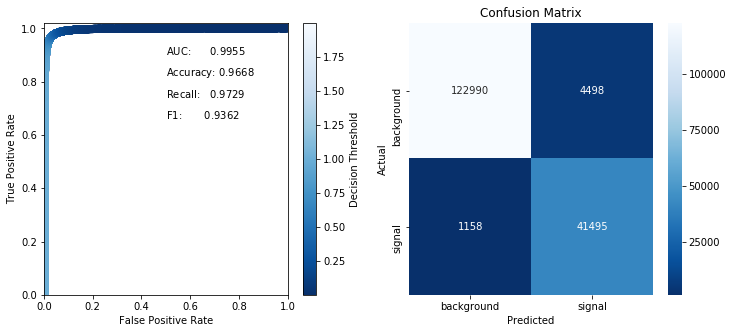

In [55]:
eval_clf(bdt, X_test[BDT_vars], y_test, label = None);

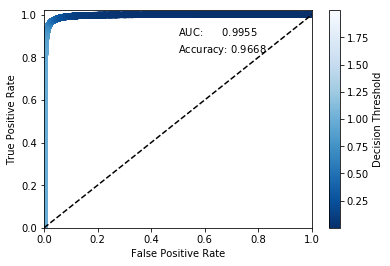

In [56]:
roc_auc_plot(bdt, X_test[BDT_vars], y_test);

### Randomized search for hyper parameter optimization

In [57]:
#from sklearn.model_selection import RandomizedSearchCV
scoring = "roc_auc"

#random_search = {
#    "n_estimators": [50, 100, 200, 350, 500, 1000],
#    "learning_rate": list(np.linspace(0, 1, 10, dtype = float)),   # default 0.3
#    "gamma": [0, 10, 100, 1000],             # default 0
#    "max_depth": list(np.linspace(1, 500, 10, dtype = int)) + [6],         # dafault 6
#    "lambda": [1, 2, 5, 10],            # default 1 (L2 regularization)
#    #"alpha": [0, 1, 5, 10],             # default 0 (L1 regularization)
#    "max_leaves": list(np.linspace(0, 200, 10, dtype = int)) + [0] ,        # default 0
#    "n_iter_no_change": [None, 5, 10]           # default None
#    }
#
#clf = XGBClassifier(seed = 101)
#model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 30, 
#                               cv = 4, verbose= -1, random_state= 101, n_jobs=16, scoring = scoring);
#
#model.fit(X_train[:20000][BDT_vars], y_train[:20000], sample_weight = X_train["weights"]); # only use subset of data

In [58]:
#df_results = pd.DataFrame(model.cv_results_)

In [59]:
pd.set_option("max_rows", 30)
pd.set_option("max_columns", 20)
#df_results

In [60]:
#model.best_params_

### Grid search to find best parameters

In [61]:
#from sklearn.model_selection import GridSearchCV

#grid_search = {
#    "learning_rate": [0.1, 0.33, 0.5],   # default 0.3
#    "max_depth": [1, 2, 4, 6, 7, 10],         # dafault 6
#    "lambda": [1, 2],            # default 1
#    "max_leaves": [0, 10, 200],
#    "n_estimators": list(np.linspace(0, 1000, 10, dtype = int)),
#}
#
#clf = XGBClassifier(seed = 101, n_iter_no_change = 5)
#model_grid = GridSearchCV(estimator = clf, param_grid = grid_search, cv = 4, verbose= -1, n_jobs=16, scoring = scoring);
#
#model_grid.fit(X_train[:40000][BDT_vars], y_train[:40000], sample_weight = X_train[:40000]["weights"])

In [62]:
#df_grid = pd.DataFrame(model_grid.cv_results_)
#df_grid.to_csv("gridsearch_new.csv")

In [63]:
#df_grid

In [64]:
#df_grid = pd.DataFrame(model_grid.cv_results_)
#df_grid.to_csv("gridsearch.csv")

In [65]:
df_grids = pd.read_csv("gridsearch_new.csv")
df_grids

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lambda,param_learning_rate,param_max_depth,param_max_leaves,param_n_estimators,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0,0.058797,0.018750,0.015291,0.002897,1,0.1,1,0,0,...,0.500000,0.500000,0.000000,973,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000e+00
1,1,3.014217,0.091280,0.035204,0.002132,1,0.1,1,0,111,...,0.992311,0.992903,0.000683,967,0.993085,0.993319,0.993502,0.993853,0.993440,2.804826e-04
2,2,5.964115,0.029570,0.059171,0.002294,1,0.1,1,0,222,...,0.994500,0.994859,0.000549,961,0.995181,0.995458,0.995550,0.995761,0.995488,2.082695e-04
3,3,8.827159,0.137779,0.078016,0.002437,1,0.1,1,0,333,...,0.995036,0.995363,0.000508,943,0.995797,0.996100,0.996116,0.996295,0.996077,1.790615e-04
4,4,11.343803,0.213750,0.096753,0.003502,1,0.1,1,0,444,...,0.995260,0.995571,0.000486,931,0.996071,0.996391,0.996374,0.996521,0.996339,1.648581e-04
5,5,14.249947,0.472680,0.120250,0.004168,1,0.1,1,0,555,...,0.995392,0.995669,0.000473,919,0.996235,0.996553,0.996540,0.996661,0.996497,1.585259e-04
6,6,17.469422,0.128325,0.143527,0.002869,1,0.1,1,0,666,...,0.995463,0.995720,0.000481,871,0.996344,0.996664,0.996637,0.996754,0.996600,1.538325e-04
7,7,20.015683,0.619087,0.171673,0.007988,1,0.1,1,0,777,...,0.995497,0.995757,0.000487,859,0.996443,0.996746,0.996715,0.996837,0.996685,1.468528e-04
8,8,22.496519,0.683193,0.191543,0.005202,1,0.1,1,0,888,...,0.995528,0.995783,0.000494,817,0.996513,0.996810,0.996784,0.996901,0.996752,1.446395e-04
9,9,25.651974,0.817853,0.217210,0.006399,1,0.1,1,0,1000,...,0.995536,0.995793,0.000495,799,0.996572,0.996869,0.996841,0.996956,0.996810,1.436979e-04


In [66]:
df_grids[df_grids["rank_test_score"] < 30]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lambda,param_learning_rate,param_max_depth,param_max_leaves,param_n_estimators,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
67,67,63.101500,0.484429,0.544259,0.029385,1,0.10,4,0,777,...,0.996388,0.996437,0.000450,13,0.999966,0.999962,0.999943,0.999934,0.999951,1.326431e-05
68,68,70.186378,2.488568,0.641722,0.018668,1,0.10,4,0,888,...,0.996373,0.996435,0.000446,19,0.999987,0.999984,0.999972,0.999971,0.999978,7.239077e-06
69,69,79.290451,1.076282,0.786653,0.028188,1,0.10,4,0,1000,...,0.996419,0.996465,0.000433,1,0.999996,0.999995,0.999989,0.999991,0.999993,2.972230e-06
77,77,62.414785,1.571551,0.562753,0.022464,1,0.10,4,10,777,...,0.996388,0.996437,0.000450,13,0.999966,0.999962,0.999943,0.999934,0.999951,1.326431e-05
78,78,70.592565,0.928980,0.638239,0.034362,1,0.10,4,10,888,...,0.996373,0.996435,0.000446,19,0.999987,0.999984,0.999972,0.999971,0.999978,7.239077e-06
79,79,77.674051,2.907561,0.733839,0.027139,1,0.10,4,10,1000,...,0.996419,0.996465,0.000433,1,0.999996,0.999995,0.999989,0.999991,0.999993,2.972230e-06
87,87,61.388726,2.314372,0.553178,0.011188,1,0.10,4,200,777,...,0.996388,0.996437,0.000450,13,0.999966,0.999962,0.999943,0.999934,0.999951,1.326431e-05
88,88,72.175963,1.015884,0.655567,0.012172,1,0.10,4,200,888,...,0.996373,0.996435,0.000446,19,0.999987,0.999984,0.999972,0.999971,0.999978,7.239077e-06
89,89,78.372601,1.855120,0.706632,0.034452,1,0.10,4,200,1000,...,0.996419,0.996465,0.000433,1,0.999996,0.999995,0.999989,0.999991,0.999993,2.972230e-06
248,248,67.126005,1.027966,0.688443,0.005394,1,0.33,4,0,888,...,0.996444,0.996433,0.000459,25,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [67]:
#model_grid.best_score_

In [68]:
#model_grid.best_params_

The array of (signal and background) training samples is called `training_samples`, the list of labels is called `training_labels`, and the weights for each event is contained in the list `training_events`.

In order to avoid overtraining, we want split the data to train the classifier on one part and classify
only the "unseen" part. Since we do not want to "waste" any data just for testing,
we [cross-validate](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) using the implementation in `sklearn.model_selection.StratifiedKFold`.

**Make sure that you always apply the right BDT to the right training sample (the one you trained it on)!**

**Ex 4.3: Define a folding and train one BDT per fold, training on $\frac{n-1}{n}$ and testing on $\frac{1}{n}$ of the training data**

In [69]:
# best parameters from grid search
params = {
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "max_depth": 4,
    #"max_leaves": 0,
    "lambda": 1,
    "n_iter_no_change": 5,
}

from sklearn.model_selection import StratifiedKFold

n_splits = 5

cv = StratifiedKFold(n_splits=n_splits, random_state = 42)

classifier = []
train_indices = []
test_indices = []

for i, (train_index, test_index) in enumerate(cv.split(data, label)):
    print("Fold: ", i+1)
    train_indices.append(train_index)
    test_indices.append(test_index)
    
    X_train = data[BDT_vars].iloc[train_index]
    weights = data["weights"].iloc[train_index]
    y_train = label[train_index]
    
    # takes very long so commented out
    clf = XGBClassifier(seed = 101, n_iter_no_change = 5, nthread = 16,
                       n_estimators = params["n_estimators"],
                       learning_rate = params["learning_rate"],
                       max_depth = params["max_depth"],
                       #max_leaves = params["max_leaves"],
                       reg_lambda = params["lambda"]
                       )
    clf.fit(X_train, y_train, sample_weight = weights)
    classifier.append(clf)

/opt/miniconda/envs/root_forge_ng/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/opt/miniconda/envs/root_forge_ng/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specif

Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5


In [70]:
for i, clf in enumerate(classifier):
    clf.save_model(f"bdt_{i}.model")

In [71]:
if not classifier:
    for i in range(n_splits):
        temp = XGBClassifier()
        temp.load_model(f'bdt_{i}.model')
        classifier.append(temp)

### Function to plot train vs test perfomance

In [72]:
import uncertainties as unc
import uncertainties.unumpy as unp
from uncertainties import ufloat

def clf_train_test_performance(clf, X_train, X_test, y_train, y_test, label = None):
    preds_proba_train = clf.predict_proba(X_train)
    preds_proba_test = clf.predict_proba(X_test)

    bins = np.linspace(0, 1, 51)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.sum(bins[1:] - bins[:-1]) / len(centers)

    fig = plt.figure()
    ax = fig.subplots(1, 1)

    ax.hist(
        preds_proba_train[:, 1][y_train == 1],
        bins=bins,
        color="red",
        label="Signal (training)",
        alpha=0.4,
        density=True,
        edgecolor="red",
        lw=1.2,
    )
    ax.hist(
        preds_proba_train[:, 1][y_train == 0],
        bins=bins,
        color="blue",
        label="Background (training)",
        alpha=0.4,
        density=True,
        edgecolor="blue",
        lw=1.2,
    )
    counts, _ = np.histogram(
        preds_proba_test[:, 1][y_test == 1], bins=bins, density=False
    )
    counts = unp.uarray(counts, np.sqrt(counts))
    counts_norm = counts / (len(preds_proba_test[:, 1][y_test == 1]) * width)

    ax.errorbar(
        centers,
        unp.nominal_values(counts_norm),
        unp.std_devs(counts_norm),
        lw=0,
        elinewidth=1,
        color="red",
        marker=".",
        label="Signal (test)",
    )

    counts, _ = np.histogram(
        preds_proba_test[:, 1][y_test == 0], bins=bins, density=False
    )
    counts = unp.uarray(counts, np.sqrt(counts))
    counts_norm = counts / (len(preds_proba_test[:, 1][y_test == 0]) * width)

    ax.errorbar(
        centers,
        unp.nominal_values(counts_norm),
        unp.std_devs(counts_norm),
        lw=0,
        elinewidth=1,
        color="blue",
        marker=".",
        label="Background (test)",
    )

    ax.set_ylabel("Counts (a.u.)")
    ax.set_xlabel("Classifier Response")
    ax.set_yscale("log")
    if label != None:
        ax.set_title(label)
    ax.legend()
    return fig

As usual a plot can give you a quick idea of what you are doing is correct.

**Ex 4.4: Plot the distribution of the BDT output for the singal and background samples to visualize the classification.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Make sure to apply the right BDT to the right sample. And a logarithmic scale may be useful again.
</a></h4>

Classifier nr. 1
roc_auc score:   0.997395854379263
Accuracy:        0.9753322244491334
Recall:          0.9795353852645398


Classifier nr. 2
roc_auc score:   0.9970254637605662
Accuracy:        0.97445648021347
Recall:          0.9755034107691226


Classifier nr. 3
roc_auc score:   0.9971997027513958
Accuracy:        0.975496793835701
Recall:          0.976370754119881


Classifier nr. 4
roc_auc score:   0.9971029387094323
Accuracy:        0.9754732839233342
Recall:          0.9753158770716613


Classifier nr. 5
roc_auc score:   0.9972564620002423
Accuracy:        0.9751322440343246
Recall:          0.976135777579821




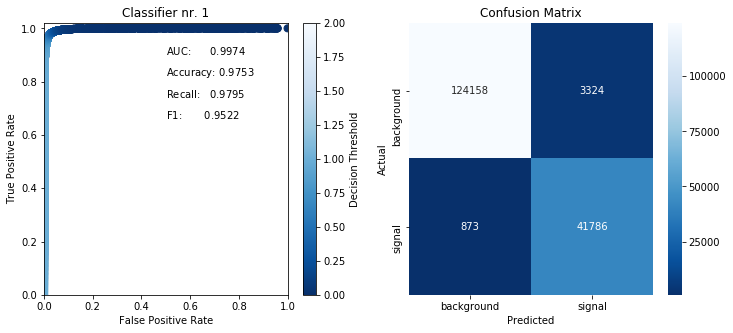

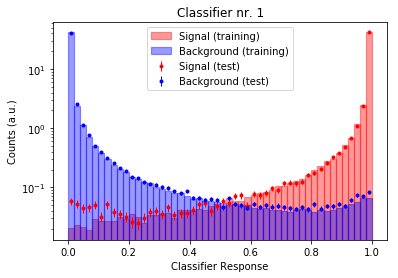

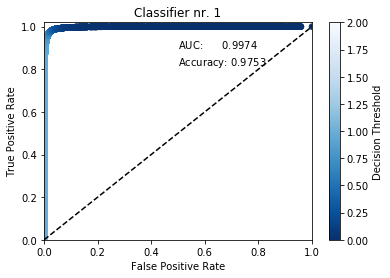

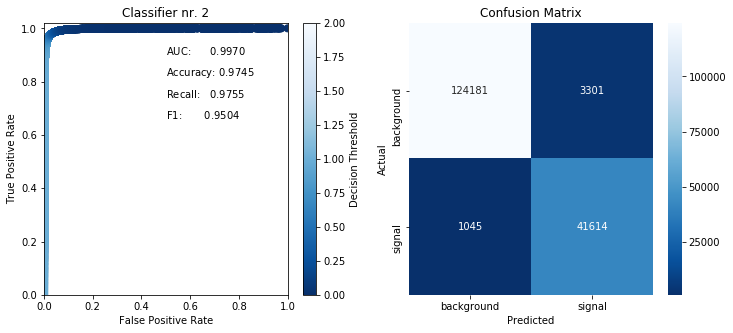

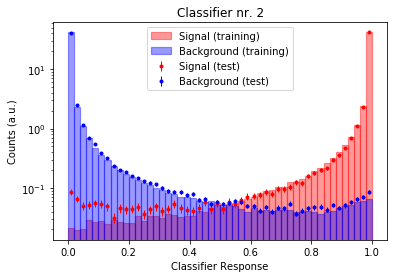

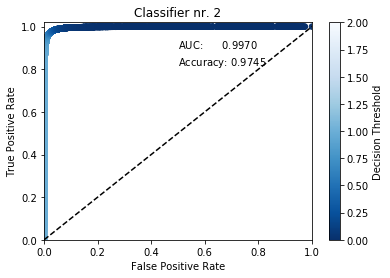

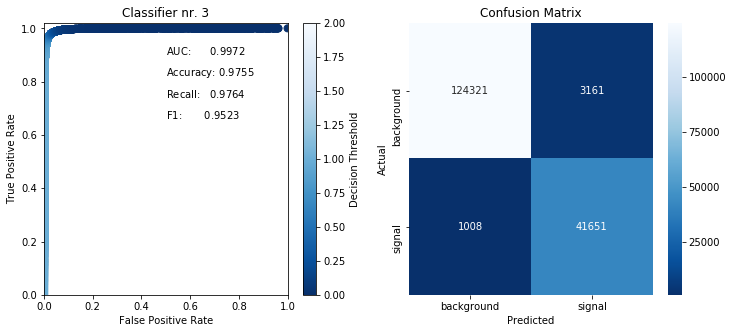

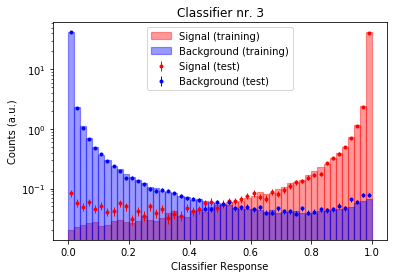

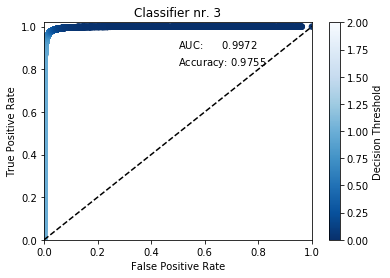

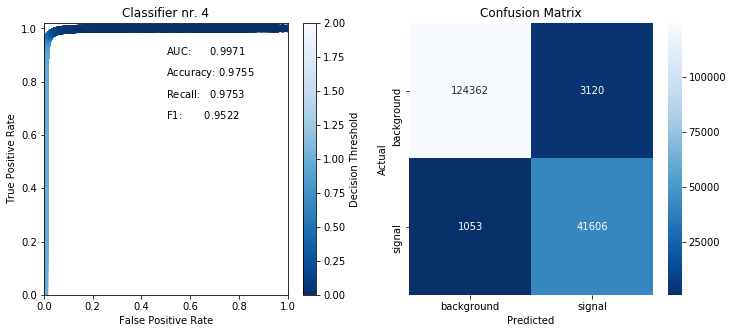

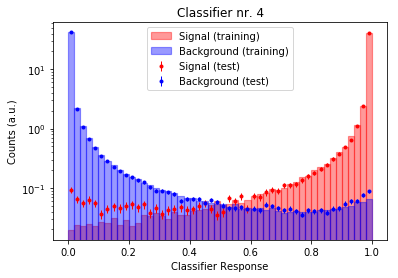

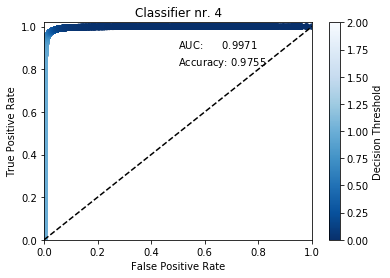

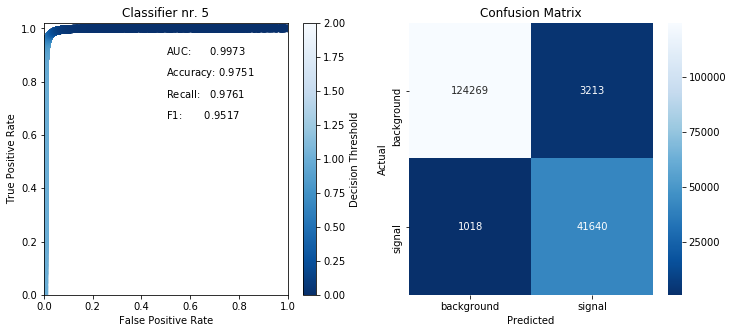

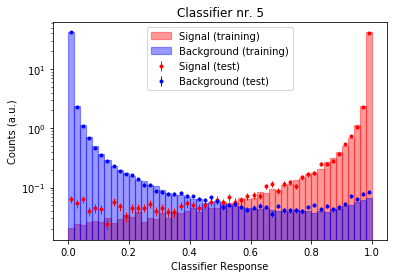

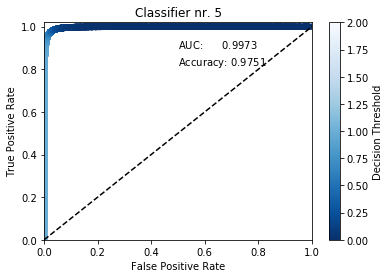

In [73]:
for i in range(n_splits):
    X_train = data.iloc[train_indices[i]][BDT_vars]
    X_test = data.iloc[test_indices[i]][BDT_vars]
    y_train = label[train_indices[i]]
    y_test = label[test_indices[i]]
    
    fig1 = eval_clf(classifier[i], X_test, y_test, label = f"Classifier nr. {i+1}")
    fig2 = clf_train_test_performance(classifier[i], X_train, X_test, y_train, y_test, 
                               label = f"Classifier nr. {i+1}")
    fig3 = roc_auc_plot(classifier[i], X_test, y_test, label = f"Classifier nr. {i+1}")
    fig1.savefig(f"plots/BDT/BDT_evaluation{i}.pdf")
    fig2.savefig(f"plots/BDT/BDT_train_test{i}.pdf")
    fig3.savefig(f"plots/BDT/BDT_roc_auc{i}.pdf")

Now that our model consisting of $n$ BDTs is trained, we want to check how well it did! As metric we choose to look at the [Reciever-Operating-Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under its curve.

**Ex 4.5: Evaluate the performance of your classifier by plotting the ROC curve and calculating the area under the curve for every BDT you trained. Do not evaluate the signal region of the data yet.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
Make sure you apply the right BDt to the right sample. Check out `sklearn` for an implementation of the ROC curve.
</a></h4>

### Perform classification

In [74]:
for i in range(n_splits):
    name = f"BDT_{i+1}"
    df_data[name] = 1
    df_MC[name] = 1
    df_MC_ctrl[name] = 1
    df_data[name] = classifier[i].predict_proba(df_data[BDT_vars])[:, 1]
    df_MC[name] = classifier[i].predict_proba(df_MC[BDT_vars])[:, 1]
    df_MC_ctrl[name] = classifier[i].predict_proba(df_MC_ctrl[BDT_vars])[:, 1]

names = ["BDT_1", "BDT_2", "BDT_3", "BDT_4", "BDT_5"]
df_data["BDT_mean"] = df_data[names].mean(axis = 1)
df_MC["BDT_mean"] = df_MC[names].mean(axis = 1)
df_MC_ctrl["BDT_mean"] = df_MC_ctrl[names].mean(axis = 1)

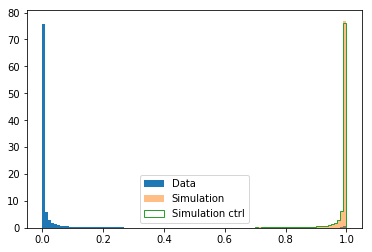

In [75]:
_, bins, _ = plt.hist(df_data["BDT_mean"], density = True, bins = 100, label = "Data")
plt.hist(df_MC["BDT_mean"], bins = bins, density = True, label = "Simulation", alpha = .5);
plt.hist(df_MC_ctrl["BDT_mean"], bins = bins, density = True, label = "Simulation ctrl", histtype = "step")
plt.legend();

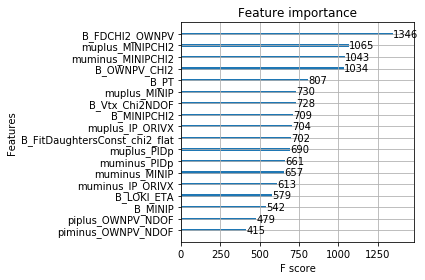

In [76]:
import xgboost
xgboost.plot_importance(classifier[0]);
plt.tight_layout()
plt.savefig("plots/BDT/feature_importance.pdf")

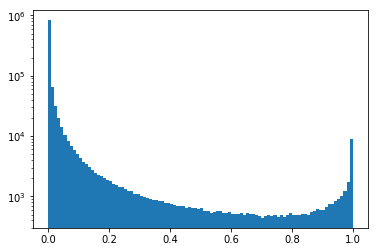

In [77]:
_, bins , _ = plt.hist(df_data["BDT_5"], bins = 100)
#plt.hist(df_MC["BDT_mean"], bins = bins, density = True);
#plt.hist(df_MC_ctrl["BDT_mean"], bins = bins, density = True, alpha = .5);
plt.yscale("log")

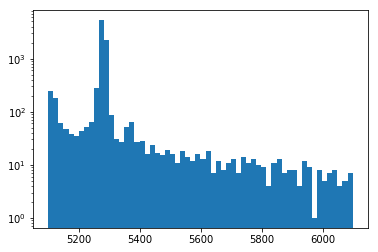

In [78]:
plt.hist(df_data[df_data["BDT_mean"] > 0.988]["B_FitDaughtersConst_M_flat"], bins = 60);
plt.yscale("log")

## 5. Classification threshold optimization
Now that we have our predictions, we would like to define a value at which we split the datasets into signal and background. We go with the following definition of a measure for signal sensitivity/significance:   
$s = \frac{\epsilon_{sig}}{5/2 + \sqrt{n_{bkg}}}$,  
where $\epsilon_{sig}$ is the efficiency of our selection regarding signal and $n_{bkg}$ is the number of background events in the signal region.

We compute the significance for several possible splitting points from 0 to 1. Eventually, we choose the cut-off leading to the highest significance.

First though, we need to compute the signal efficiency and number of background events in the signal region serving as input to our FOM.

**Ex 5.1: Find a way to estimate the signal efficiency and the number of background events in the signal region(!) depending on the cut on the BDT output.**

In [79]:
print("Signal window: ", signal_window)
xr = (5100, 6100)
print("Fit range: ", xr)

Signal window:  (5333, 5395)
Fit range:  (5100, 6100)


In [80]:
import iminuit

In [81]:
iminuit.__version__

'2.17.0'

In [82]:
from iminuit import cost, Minuit
from scipy.stats import truncnorm, norm, expon, truncexpon#, crystalball_ex
from scipy.integrate import quad

def background_model(x, b, tau):
    return b, b * truncexpon.pdf(x, b=(xr[1]-xr[0])/tau, loc=xr[0], scale=tau)

def efficiency(df, cut):
    return len(df[df["BDT_mean"] >= cut])/len(df)

def get_background(df, cut, window):
    mask = df["BDT_mean"] >= cut
    X = df[mask]["B_FitDaughtersConst_M_flat"]
    if len(X) == 0:
        return 0
    c = cost.ExtendedUnbinnedNLL(X, background_model)

    m = Minuit(c, b = len(X), tau=200)
    m.limits["b"] = (1, len(X)+1e3)
    m.limits["tau"] = (0, None)
    
    c.mask = signal_window[1] < X # (X < signal_window[0]) | (signal_window[1] < X) <-- ignores B_d peak

    m.migrad()
    B = quad(lambda x: m.values["b"] *truncexpon.pdf(x, b=(xr[1]-xr[0])/m.values["tau"], loc=xr[0], scale=m.values["tau"]), 
             *signal_window)[0]
    return B

**Ex 5.2: Determine the best cut value based on your just defined metric.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
You could for example average the best cut values of the $n$ BDTs to combine them to a total value.
</a></h4>

In [83]:
cuts = np.linspace(0.95, 1, 100)

pfom = []

for cut in tqdm(cuts):
    eff = efficiency(df_MC, cut)
    B = get_background(df_data, cut, signal_window)
    pfom.append(eff/(5/2 + np.sqrt(B)))

100%|██████████| 100/100 [01:33<00:00,  1.06it/s]


In [84]:
cut = cuts[np.argmax(pfom)]
print("Best cut: ", cut)

Best cut:  0.9984848484848485


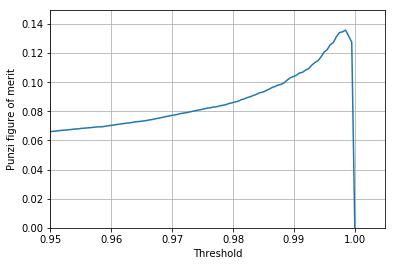

In [85]:
plt.plot(cuts, pfom)
plt.xlim(0.95, 1.005)
plt.ylim(min(pfom), 1.1*max(pfom))
plt.xlabel("Threshold")
plt.ylabel("Punzi figure of merit")
plt.grid()
plt.savefig("plots/pFOM_zoom.pdf")

## 6. Estimation of the number of $B_s$ events in the data sample
Now that we defined a best cut, lets apply our classification algorithm to the full dataset and see how well it works. We will then get the "real" signal significance by fitting the selected mass distribution.  


**Ex 6.1: Apply your classifier to the full dataset and plot the mass distribution.**

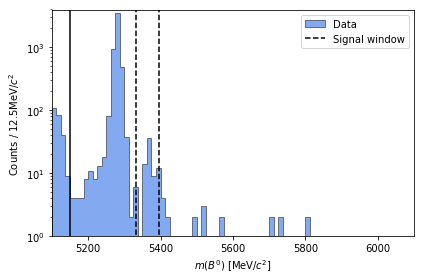

In [192]:
xr = (5100, 6100)
bins = 80

bins = np.linspace(*xr, bins+1)

centers = (bins[:-1] + bins[1:]) / 2
width = np.sum(bins[1:] - bins[:-1]) / len(centers)

fig, ax = plt.subplots(1, 1)
counts, _, _ = ax.hist(df_data[df_data["BDT_mean"] >= cut]["B_FitDaughtersConst_M_flat"], bins = bins, label = "Data", 
                       color = "cornflowerblue", alpha = .8, edgecolor = "black", lw = .6, histtype = "stepfilled")

plt.vlines(signal_window, 0, 1.1*max(counts), linestyle = "dashed", label = "Signal window")
plt.xlabel(r"$m(B^0)$ [MeV/$c^2$]")
plt.ylabel(f"Counts / {width}" + r"MeV/$c^2$")
plt.vlines(5150, 0, 10e3)
plt.legend()
plt.xlim(*xr)
plt.ylim(1, 1.1*max(counts))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
#ticks = list(ax.get_xticks()) + [m_Bs, m_Bd]
#labels = [str(int(tick)) for tick in ticks]
#labels[-2] = r"$m(B_s)$"
#labels[-1] = r"$m(B_d)$"
#plt.xticks(ticks = ticks, labels = labels)
plt.xlim(*xr)
plt.yscale("log")
plt.tight_layout();

plt.savefig("plots/mass_after_bdt.pdf")
#plt.close()

In [87]:
def DCBfit_pull_plot_signal(data, minuit, model, xrange, n_bins=20, xlabel = r"$m(B^0)$"):
    # binning the data
    bins = np.linspace(*xrange, n_bins +1)
    counts, bins = np.histogram(data, density=False, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.sum(bins[1:] - bins[:-1]) / len(centers)

    err = np.sqrt(counts)
    err[err == 0] = 1
    counts = unp.uarray(counts, err)

    params = np.array(minuit.values)

    x = np.linspace(xrange[0], xrange[1], 1000)

    fig = plt.figure(figsize=(9, 6))
    grid = fig.add_gridspec(2, 1, hspace=0.2, height_ratios=[3, 1])

    main_ax = fig.add_subplot(grid[0, 0])

    main_ax.errorbar(
        centers,
        unp.nominal_values(counts),
        yerr=unp.std_devs(counts),
        color="black",
        lw=0,
        marker=".",
        elinewidth=1,
        label="Data",
    )

    norm, values = model(x, *params)
    main_ax.plot(x, width * values, label="Fit", color="cornflowerblue")

    #main_ax.set_xlabel(r"$m(\mu^+\mu^-\mu^+\mu^-)$ [MeV/$c^2$]")
    main_ax.set_ylabel(f"Candidates / ({width:.0f} MeV/$c^2$)")
    main_ax.set_xlim(xrange[0], xrange[1])
    main_ax.set_ylim(
        0,
        1.1
        * max(
            max(width * values),
            1.2 * max(unp.nominal_values(counts) + unp.std_devs(counts)),
            4
        ),
    )
    #main_ax.set_yscale("log")
    subplot_ax = fig.add_subplot(grid[1, 0], sharex=main_ax)

    #main_ax.annotate("LHCb data", xy = (0.05, 0.90), xycoords = "axes fraction", fontsize = 18)
    main_ax.legend()

    values = unp.nominal_values(counts)
    hist_err = unp.std_devs(counts)
    hist_err[hist_err == 0] = np.nan
    values = unp.uarray(values, hist_err)
    edges = bins
    ym = np.zeros(len(values))

    for i in range(len(centers)):
        value = quad(
            lambda x: model(x, *params)[1] / norm, edges[i], edges[i + 1]
        )
        ym[i] = value[0] * len(data)
    pulls = (values - ym) / hist_err
    pulls_err = unp.std_devs(
        pulls
    )  # with this approach the error is alwys 1 sigma, assymetric errors could be added by using modelparameters with errors
    pulls = unp.nominal_values(pulls)
    pulls[(pulls == 0) | (pulls == np.inf) | (pulls == -np.inf)] = np.nan

    x2 = np.linspace(
        (xrange[0] - 0.5 * np.abs(xrange[0])), (xrange[1] + 0.5 * np.abs(xrange[1])), 10
    )
    subplot_ax.fill_between(x2, -1, 1, alpha=0.3, label=r"$1\sigma$")
    subplot_ax.errorbar(
        centers,
        pulls,
        yerr=pulls_err,
        color="black",
        marker=".",
        linestyle="none",
    )

    y_lim_max = (
        np.max(
            np.abs(pulls[~np.isnan(pulls) & ~np.isnan(pulls_err)])
            + pulls_err[~np.isnan(pulls) & ~np.isnan(pulls_err)]
        )
        * 1.2
    )
    subplot_ax.set_ylim([-y_lim_max, y_lim_max])
    subplot_ax.axhline(0, color="black", linestyle="dashed", linewidth=1.0)
    subplot_ax.set_ylabel("Pulls")
    subplot_ax.set_xlabel(xlabel)
    return fig

You should see two peaks when plotting on a log-scale.

Now we have to find out what efficiency vs background retention we are getting here. Therefore, we need to model the entire distribution. This model should consist of two peaking structures ($B^0$ and $B_s$) and one exponential background component. To build a stable model, we first fit the peaks to their respective simulation and fix the obtained shape parameters in the fit to data. To ensure that the peaks in simulation match the peak shape in data, you need to classify both signal samples and apply the BDT cut before performing the fit.

I recommend using the [`zfit`](https://zfit.readthedocs.io/en/latest/) library for fitting. But again, this is just one of many good choices that you are free to take.

**Ex 6.2: Fit a peak to the signal simulation.**
<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Maybe ONE Gaussian is not enough?</a></h4>

In [193]:
xr = (5200, 6100)

In [194]:
def crystalball_pdf(x, beta_l, m_l, sigma_l, beta_r, m_r, sigma_r, mu):
    A_l = ((m_l / beta_l)**m_l) * np.exp(-beta_l**2 / 2)
    B_l = m_l / beta_l - beta_l
    A_r = ((m_r / beta_r)**m_r) * np.exp(-beta_r**2 / 2)
    B_r = m_r / beta_r - beta_r
    
    x_l = (x - mu) / sigma_l
    x_r = (x - mu) / sigma_r
    
    left_tail = A_l * (B_l - x_l)**(-m_l) * (x_l < -beta_l)
    right_tail = A_r * (B_r + x_r)**(-m_r) * (x_r > beta_r)
    central = np.exp(-x_l**2 / 2) * (np.abs(x_l) <= beta_l) * (np.abs(x_r) <= beta_r)
    
    return left_tail + central + right_tail

# requires numba stats
#def model_peak(x, s, beta_l, m_l, sigma_l, beta_r, m_r, sigma_r, mu):
#    return s, s * crystalball.pdf(x, beta_l, m_l, sigma_l, beta_r, m_r, sigma_r, mu)

# doesn't work
#def model_peak(x, s, beta_l, m_l, sigma_l, beta_r, m_r, sigma_r, mu):
#    return s, s * crystalball_pdf(x, beta_l, m_l, sigma_l, beta_r, m_r, sigma_r, mu)

def model_peak(x, s, mu, scale):
    return s, s* norm.pdf(x, loc = mu, scale = scale)

In [195]:
X = df_MC[df_MC["BDT_mean"] >= cut]["B_FitDaughtersConst_M_flat"]

nll_MC = cost.ExtendedUnbinnedNLL(X, model_peak)

m_MC = Minuit(
    nll_MC,
    s=len(X),
    #beta_l=1,
    #m_l=2,
    #sigma_l=20,
    #beta_r=1,
    #m_r=2,
    #sigma_r=20,
    mu=m_Bs,
    scale = 50
)

m_MC.limits["mu"] = (5200, 5500)
m_MC.limits["scale"] = (0.1, 500)
#m_MC.limits["sigma_l", "sigma_r"] = (0.00001, 100)
#m_MC.limits["beta_l", "beta_r"] = (0, 10)
#m_MC.limits["m_l", "m_r"] = (1, 1000)
#m_MC.limits["s"] = (1, len(X) + 1e3)
m_MC.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.728e+06                 │              Nfcn = 73               │
│ EDM = 1.54e-05 (Goal: 0.0002)    │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 119.10e3  │  0.34e3   │            │            │         │         │       │
│ 1 │ mu    │5.366862e3 │0.000022e3 │            │            │  5200   │  5500   │       │
│ 2 │ scale │   7.479   │   0.015   │            │            │   0.1   │   500   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        s       mu    scale │
├───────┼────────────────────────────┤
│     s │ 1.19e+05 2.13e-09    6e-09 │
│    mu │ 2.13e-09  0.00047  4.3e-07 │
│ scale │    6e-09  4.3e-07 0.000235 │
└───────┴────────────────────────────┘

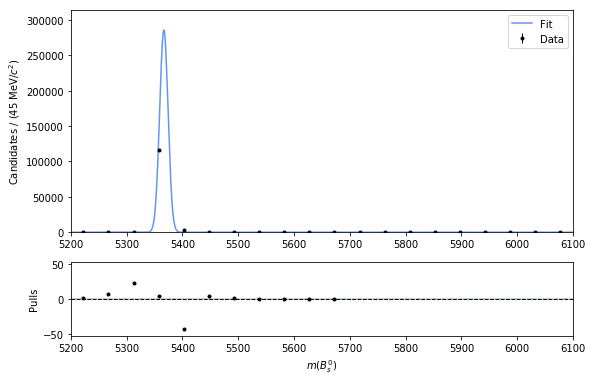

In [196]:
fig = DCBfit_pull_plot_signal(X, m_MC, model_peak, xrange = xr, n_bins=20, xlabel = r"$m(B^0_s)$")

Now that you have the shape parameters of the signal mass peak, we do the same for the $B^0$ peak.

**Ex 6.3: Fit a peak to the BDT selected $B^0$ simulation.**

In [197]:
X = df_MC_ctrl[df_MC_ctrl["BDT_mean"] >= cut]["B_FitDaughtersConst_M_flat"]

nll_MC_ctrl = cost.ExtendedUnbinnedNLL(X, model_peak)

m_MC_ctrl = Minuit(
    nll_MC_ctrl,
    s=len(X),
    #beta_l=1,
    #m_l=2,
    #sigma_l=20,
    #beta_r=1,
    #m_r=2,
    #sigma_r=20,
    mu=m_Bd,
    scale = 50
)

m_MC_ctrl.limits["mu"] = (5200, 5500)
m_MC_ctrl.limits["scale"] = (0.1, 500)
#m_MC_ctrl.limits["sigma_l", "sigma_r"] = (0.00001, 100)
#m_MC_ctrl.limits["beta_l", "beta_r"] = (0, 10)
#m_MC_ctrl.limits["m_l", "m_r"] = (1, 1000)
#m_MC_ctrl.limits["s"] = (1, len(X) + 1e3)
m_MC_ctrl.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.193e+06                 │              Nfcn = 73               │
│ EDM = 5.96e-05 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  85.47e3  │  0.29e3   │            │            │         │         │       │
│ 1 │ mu    │5.279672e3 │0.000024e3 │            │            │  5200   │  5500   │       │
│ 2 │ scale │   7.080   │   0.017   │            │            │   0.1   │   500   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         s        mu     scale │
├───────┼───────────────────────────────┤
│     s │  8.55e+04 -2.91e-09  2.06e-09 │
│    mu │ -2.91e-09  0.000587  5.46e-07 │
│ scale │  2.06e-09  5.46e-07  0.000293 │
└───────┴───────────────────────────────┘

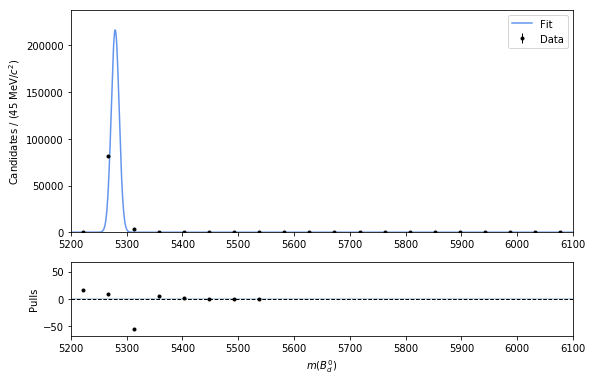

In [198]:
fig = DCBfit_pull_plot_signal(X, m_MC_ctrl, model_peak, xrange = xr, n_bins=20, xlabel = r"$m(B^0_d)$")

You have set up an awesome classifier but it may not be able to catch all combinatorial background in the data sample. Therefore, you should also include a background component into your model. A common choice for combinatorial background is a decreasing exponential function.

**Ex 6.4: Fit the full data mass with the fixed peak shapes and an exponential background.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
Don't forget to include a scale factor for each component.
</a></h4>

In [199]:
#def fullmodel(x, 
#              s_Bd, beta_l_Bd, m_l_Bd, sigma_l_Bd, beta_r_Bd, m_r_Bd, sigma_r_Bd, mu_Bd,
#              s_Bs, beta_l_Bs, m_l_Bs, sigma_l_Bs, beta_r_Bs, m_r_Bs, sigma_r_Bs, mu_Bs,
#              b, tau):
#    return s_Bd+ s_Bs + b, b*truncexpon.pdf(x, *xr, 0.0, tau) + s_Bd * crystalball_ex.pdf(
#        x, beta_l_Bd, m_l_Bd, sigma_l_Bd, beta_r_Bd, m_r_Bd, sigma_r_Bd, mu_Bd) + s_Bs * crystalball_ex.pdf(
#        x, beta_l_Bs, m_l_Bs, sigma_l_Bs, beta_r_Bs, m_r_Bs, sigma_r_Bs, mu_Bs)

def fullmodel(x, s_Bs, s_Bd, mu_Bd, mu_Bs, sigma_B, ratio, b ,tau):
    return b + s_Bs + s_Bd, b* truncexpon.pdf(x, b=(xr[1]-xr[0])/tau, loc=xr[0], scale=tau) + s_Bs * norm.pdf(
        x, loc = mu_Bs, scale = sigma_B*ratio) + s_Bd * norm.pdf(
        x, loc = mu_Bd, scale = sigma_B)

In [200]:
X = df_data[df_data["BDT_mean"] >= cut]["B_FitDaughtersConst_M_flat"]
X = X[X > xr[0]]

nll = cost.ExtendedUnbinnedNLL(X, fullmodel)
m = Minuit(
    nll,
    s_Bd=len(X) / 2,
    s_Bs=10,
    b=len(X) / 2,
    tau=200,
    mu_Bd=m_MC_ctrl.params["mu"].value,
    #offset = m_MC.params["mu"].value-m_MC_ctrl.params["mu"].value,
    mu_Bs=m_MC.params["mu"].value,
    #beta_l_Bd=m_MC_ctrl.params["beta_l"].value,
    #m_l_Bd=m_MC_ctrl.params["m_l"].value,
    #sigma_l_Bd=m_MC_ctrl.params["sigma_l"].value,
    #beta_r_Bd=m_MC_ctrl.params["beta_r"].value,
    #m_r_Bd=m_MC_ctrl.params["m_r"].value,
    #sigma_r_Bd=m_MC_ctrl.params["sigma_r"].value,
    #beta_l_Bs=m_MC.params["beta_l"].value,
    #m_l_Bs=m_MC.params["m_l"].value,
    #sigma_l_Bs=m_MC.params["sigma_l"].value,
    #beta_r_Bs=m_MC.params["beta_r"].value,
    #m_r_Bs=m_MC.params["m_r"].value,
    #sigma_r_Bs=m_MC.params["sigma_r"].value,
    sigma_B=m_MC_ctrl.params["scale"].value,
    ratio=m_MC.params["scale"].value/m_MC_ctrl.params["scale"].value
    #sigma_Bd=m_MC_ctrl.params["scale"].value,
)

#m.fixed["sigma_l_Bd", "sigma_r_Bd", "beta_l_Bd", "beta_r_Bd", "m_l_Bd", "m_r_Bd", "mu_Bd",
#       "sigma_l_Bs", "sigma_r_Bs", "beta_l_Bs", "beta_r_Bs", "m_l_Bs", "m_r_Bs", "mu_Bs"] = True

m.fixed["ratio"] = True

m.limits["s_Bs", "s_Bd", "b"] = (0, len(X))
#m.limits["mu_Bs", "mu_Bd"] = (5200, 5500)
m.limits["tau"] = (0, None)
m.print_level = 1
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.263e+04                 │              Nfcn = 322              │
│ EDM = 8.83e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s_Bs    │    45     │     8     │            │            │    0    │  5286   │       │
│ 1 │ s_Bd    │  5.01e3   │  0.07e3   │            │            │    0    │  5286   │       │
│ 2 │ mu_Bd   │ 5.27987e3 │ 0.00009e3 │            │            │         │         │       │
│ 3 │ mu_Bs   │ 5.3673e3  │ 0.0012e3  │            │            │         │         │       │
│ 4 │ sigma_B │   6.21    │   0.08    │            │            │         │         │       │
│ 5 │ ratio   │   1.056   │   0.011   │            │            │         │         │  yes  │
│ 6 │ b       │    233    │    19     │            │            │    0    │  5286   │       │
│ 7 │ tau     │    140    │    10     │            │            │    0    │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────────────────────────────────────────────────────────────┐
│         │      s_Bs      s_Bd     mu_Bd     mu_Bs   sigma_B     ratio         b       tau │
├─────────┼─────────────────────────────────────────────────────────────────────────────────┤
│    s_Bs │      58.3      5.28  -0.00287     0.217    0.0225         0     -18.8    -0.334 │
│    s_Bd │      5.28  5.11e+03   -0.0564      0.17     0.353         0      -103      26.9 │
│   mu_Bd │  -0.00287   -0.0564   0.00825 -0.000103 -0.000263         0    0.0597   -0.0277 │
│   mu_Bs │     0.217      0.17 -0.000103      1.36   0.00206         0    -0.388   -0.0618 │
│ sigma_B │    0.0225     0.353 -0.000263   0.00206   0.00565         0    -0.378    0.0984 │
│   ratio │         0         0         0         0         0         0         0         0 │
│       b │     -18.8      -103    0.0597    -0.388    -0.378         0       356     -26.8 │
│     tau │    -0.334      26.9   -0.0277   -0.0618    0.0984         0     -26.8      97.9 │
└─────────┴─────────────────────────────────────────────────────────────────────────────────┘

In [201]:
m.values["s_Bd"]

5008.632031685916

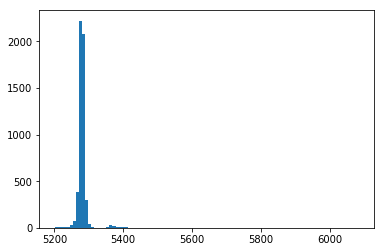

In [202]:
plt.hist(X, bins = 100);

**Ex 6.5: Plot the fully fitted model, its 3 submodels and the selected data distribution**

In [203]:
def DCBfit_pull_plot(
    data, minuit, model, xrange, n_bins=20):
    # binning the data
    bins = np.linspace(*xrange, n_bins +1)
    counts, bins = np.histogram(data, density=False, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.sum(bins[1:] - bins[:-1]) / len(centers)

    err = np.sqrt(counts)
    err[err == 0] = 1
    counts = unp.uarray(counts, err)

    params = np.array(minuit.values)

    x = np.linspace(xrange[0], xrange[1], 1000)

    fig = plt.figure(figsize=(9, 6))
    grid = fig.add_gridspec(2, 1, hspace=0.2, height_ratios=[3, 1])

    main_ax = fig.add_subplot(grid[0, 0])

    main_ax.errorbar(
        centers,
        unp.nominal_values(counts),
        yerr=unp.std_devs(counts),
        color="black",
        lw=0,
        marker=".",
        elinewidth=1,
        label="Data",
    )

    norm, values = model(x, *params)
    main_ax.plot(x, width * values, label="Total", color="cornflowerblue")
    
    b, y = background_model(x, minuit.params["b"].value, minuit.params["tau"].value)
    main_ax.plot(x, width*y, label="Combinatorial", ls="dashed", color="grey")
    
    s1, y = model_peak(x, minuit.params["s_Bs"].value, 
                        minuit.params["mu_Bs"].value, 
                        minuit.params["sigma_B"].value*minuit.params["ratio"].value)
    main_ax.plot(x, width * y, label=r"$B_s$", color="firebrick")
    
    s2, y = model_peak(x, minuit.params["s_Bd"].value, minuit.params["mu_B"].value, 
                                                     minuit.params["sigma_B"].value)
    main_ax.plot(x, width * y, label=r"$B_d$", color="mediumpurple", ls = "dashed")

    signal_Bs = ufloat(minuit.params["s_Bs"].value, minuit.params["s_Bs"].error)
    signal_Bd = ufloat(minuit.params["s_Bd"].value, minuit.params["s_Bd"].error)
    background = ufloat(minuit.params["b"].value, minuit.params["b"].error)

    plt.plot(
        [],
        [],
        " ",
        label=f"Signal yield ($B_s$): ${unc.nominal_value(signal_Bs):.0f} \pm {unc.std_dev(signal_Bs):.0f}$ ",
    )
    plt.plot(
        [],
        [],
        " ",
        label=f"Signal yield ($B_d$): ${unc.nominal_value(signal_Bd):.0f} \pm {unc.std_dev(signal_Bd):.0f}$ ",
    )
    plt.plot(
        [],
        [],
        " ",
        label=f"Background yield: ${unc.nominal_value(background):.0f} \pm {unc.std_dev(background):.0f}$ ",
    )

    #main_ax.set_xlabel(r"$m(\mu^+\mu^-\mu^+\mu^-)$ [MeV/$c^2$]")
    main_ax.set_ylabel(f"Candidates / ({width:.0f} MeV/$c^2$)")
    main_ax.set_xlim(xrange[0], xrange[1])
    main_ax.set_ylim(
        1e-1,
        1.4
        * max(
            max(width * values),
            1.2 * max(unp.nominal_values(counts) + unp.std_devs(counts)),
            4
        ),
    )
    main_ax.set_yscale("log")
    subplot_ax = fig.add_subplot(grid[1, 0], sharex=main_ax)

    #main_ax.annotate("LHCb data", xy = (0.05, 0.90), xycoords = "axes fraction", fontsize = 18)
    main_ax.legend()

    values = unp.nominal_values(counts)
    hist_err = unp.std_devs(counts)
    hist_err[hist_err == 0] = np.nan
    values = unp.uarray(values, hist_err)
    edges = bins
    ym = np.zeros(len(values))

    for i in range(len(centers)):
        value = quad(
            lambda x: model(x, *params)[1] / norm, edges[i], edges[i + 1]
        )
        ym[i] = value[0] * len(data)
    pulls = (values - ym) / hist_err
    pulls_err = unp.std_devs(
        pulls
    )  # with this approach the error is alwys 1 sigma, assymetric errors could be added by using modelparameters with errors
    pulls = unp.nominal_values(pulls)
    pulls[(pulls == 0) | (pulls == np.inf) | (pulls == -np.inf)] = np.nan

    x2 = np.linspace(
        (xrange[0] - 0.5 * np.abs(xrange[0])), (xrange[1] + 0.5 * np.abs(xrange[1])), 10
    )
    subplot_ax.fill_between(x2, -1, 1, alpha=0.3, label=r"$1\sigma$")
    subplot_ax.errorbar(
        centers,
        pulls,
        yerr=pulls_err,
        color="black",
        marker=".",
        linestyle="none",
    )

    y_lim_max = (
        np.max(
            np.abs(pulls[~np.isnan(pulls) & ~np.isnan(pulls_err)])
            + pulls_err[~np.isnan(pulls) & ~np.isnan(pulls_err)]
        )
        * 1.1
    )
    subplot_ax.set_ylim([-y_lim_max, y_lim_max])
    subplot_ax.axhline(0, color="black", linestyle="dashed", linewidth=1.0)
    subplot_ax.set_ylabel("Pulls")
    subplot_ax.set_xlabel(r"$m(B^0)$ [MeV/$c^2$]")
    return fig

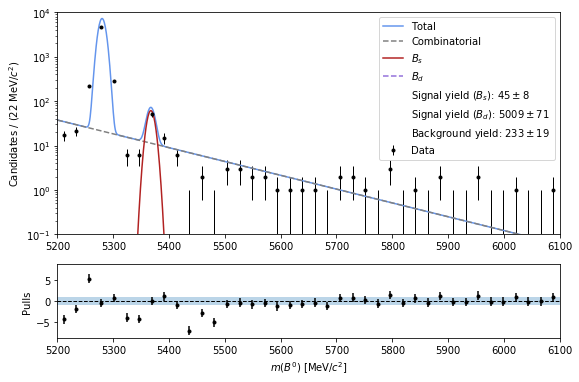

In [204]:
fig = DCBfit_pull_plot(
    X, m, fullmodel, xr, n_bins=40
)
fig.savefig("plots/final_fit.pdf")

Looking good! We see our $B_s$ peak!

Let's evaluate the statistical sigificance of our observation. The correct way of doing this is rather complicated and tedious which is beyond the scope of what we can and want to do here. Instead, we will use
$m = \frac{n_{sig}}{\sqrt{n_{sig}+n_{bkg}}}$
as a simple proxy for the statistical significance. The numbers $n_i$ are the number of signal/background events in the signal region.

**Ex 6.6: Calculate $n_{sig}$, $n_{bkg}$, and the significance proxy $m$!**

In [205]:
B = quad(lambda x: m.values["b"] * truncexpon.pdf(
    x, b=(xr[1]-xr[0])/m.values["tau"], loc=xr[0], scale=m.values["tau"]
                                                 ), *signal_window)[0]
S = quad(lambda x: m.values["s_Bs"] * norm.pdf(
        x, loc = m.values["mu_Bs"], scale = m.values["sigma_B"]*m.values["ratio"]), *signal_window)[0]

significance = S/np.sqrt(S+B)
print(f"{B:.0f}, {S:.0f}, {significance:.2f}")

32, 45, 5.10


**Congratulations! You did it. Now you are more than ready for a thesis at E5 :)**